In [1]:
import pandas as pd
import numpy as np
import git
from datetime import datetime
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
import statsmodels.api as sm
import statsmodels
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
os.system("mkdir -p ./plots")

0

In [3]:
def get_data(varname: str) -> pd.DataFrame:
    df=pd.read_csv(f"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_{varname}_global.csv")
    value_cols = [ x for x in df.columns if is_date(x)]
    
    df = df.rename(columns={"Country/Region":"Country","Province/State":"State"})
    #print(df.Country.unique())
    countries_with_province = df[~df["State"].isna()]["Country"].unique()
    df = pd.melt(df, id_vars=["Country","State"], value_vars=value_cols, var_name="Date", value_name=varname)
    today = np.max(pd.to_datetime(df["Date"]))
    print(f"Today: {today}")
    for cou in countries_with_province:
        if "nan" in [str(x) for x in df[df.Country==cou]["State"]]: continue
        df_to_add = df[df.Country==cou].groupby(["Country","Date"]).agg({varname : 'sum'}).reset_index()
        df_to_add["State"] = np.nan
        df = pd.concat([df, df_to_add]).sort_values(by=["Country","Date","State"])
    df = df.fillna("")
    return df

In [4]:
def correct_country_name(df):
    df["Country"] = df["Country"].apply(lambda x: "United States" if x == "US" else x)
    df["Country"] = df["Country"].apply(lambda x: "South Korea" if x == "Korea, South" else x)
    df["Country"] = df["Country"].apply(lambda x: "Taiwan" if x == "Taiwan*" else x)
    df["Country"] = df["Country"].apply(lambda x: "Ivory Coast" if x == "Cote d'Ivoire" else x)
    df["Country"] = df["Country"].apply(lambda x: "Czech Republic" if x == "Czechia" else x)
    df["Country"] = df["Country"].apply(lambda x: "Vatican City" if x == "Holy See" else x)
    df["Country"] = df["Country"].apply(lambda x: "Palestine" if x == "West Bank and Gaza" else x)
    df["Country"] = df["Country"].apply(lambda x: "Cape Verde" if x == "Cabo Verde" else x)
    df["Country"] = df["Country"].apply(lambda x: "Republic of the Congo" if x == "Congo (Brazzaville)" else x)
    df["Country"] = df["Country"].apply(lambda x: "DR Congo" if x == "Congo (Kinshasa)" else x)
    df["Country"] = df["Country"].apply(lambda x: "Myanmar" if x == "Burma" else x)
    return df

In [5]:
from dateutil.parser import parse

def is_date(string, fuzzy=False):
    """
    Return whether the string can be interpreted as a date.

    :param string: str, string to check for date
    :param fuzzy: bool, ignore unknown tokens in string if True
    """
    try: 
        parse(string, fuzzy=fuzzy)
        return True

    except ValueError:
        return False

### Data munging

In [6]:
df_cases = get_data(varname="confirmed")
df_deaths = get_data(varname="deaths")
df = pd.merge(df_cases, df_deaths, on=["Country","State","Date"], how="inner")
df = correct_country_name(df)
countries = df["Country"].unique()

Today: 2022-01-20 00:00:00
Today: 2022-01-20 00:00:00


In [7]:
df_pop = pd.read_csv("./data/population-by-country.csv")
df_pop = df_pop.rename(columns={"name":"Country"})[["Country","pop2020","pop2021"]]

df = pd.merge(df, df_pop, on=["Country"], how="inner")
df["Date"] = pd.to_datetime(df["Date"])

print(sorted(set(df_pop.Country.unique()) - set(countries)))
print(sorted(set(countries) - set(df_pop.Country.unique())))

['American Samoa', 'Anguilla', 'Aruba', 'Bermuda', 'British Virgin Islands', 'Cayman Islands', 'Cook Islands', 'Curacao', 'Falkland Islands', 'Faroe Islands', 'French Guiana', 'French Polynesia', 'Gibraltar', 'Greenland', 'Guadeloupe', 'Guam', 'Hong Kong', 'Isle of Man', 'Macau', 'Martinique', 'Mayotte', 'Montserrat', 'Nauru', 'New Caledonia', 'Niue', 'North Korea', 'Northern Mariana Islands', 'Puerto Rico', 'Reunion', 'Saint Barthelemy', 'Saint Martin', 'Saint Pierre and Miquelon', 'Sint Maarten', 'Tokelau', 'Turkmenistan', 'Turks and Caicos Islands', 'Tuvalu', 'United States Virgin Islands', 'Wallis and Futuna', 'Western Sahara']
['Diamond Princess', 'Kosovo', 'MS Zaandam', 'Summer Olympics 2020']


In [8]:
df = df.sort_values(by=["Country","Date"])
for varname in ["confirmed","deaths"]:
    df[f"{varname}_1000"] = df[f"{varname}"]/df["pop2021"]
    df[f"daily_{varname}"] = df[varname] - df.groupby(["Country","State"])[varname].shift(1)
    df[f"daily_{varname}_1000"] = df[f"daily_{varname}"]/df["pop2021"]
    df[f"daily_{varname}_mean_7d_1000"] = df.groupby(["Country","State"])[f"daily_{varname}_1000"].apply(lambda x: x.rolling(7).mean())
    
    df[f"{varname}_last_7d"] = df.groupby(["Country","State"])[f"daily_{varname}"].apply(lambda x: x.rolling(7).sum())
    df[f"{varname}_last_7d_1000"] = df[f"{varname}_last_7d"]/df["pop2021"]

### Vaccination data

In [9]:
df_vax = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv")
df_vax = df_vax.rename(columns={"location":"Country", "date":"Date"})
df_vax["Date"] = pd.to_datetime(df_vax["Date"])
df_vax = df_vax[["Country","Date","people_fully_vaccinated"]]
df_vax = correct_country_name(df_vax)

In [10]:
df = pd.merge(df, df_vax, on=["Country","Date"], how="left")
df["people_fully_vaccinated"] = df["people_fully_vaccinated"].ffill()
df["pop_fully_vaccinated"] = df["people_fully_vaccinated"]/(df["pop2021"]*1000)
df["Date"] = pd.to_datetime(df["Date"])

In [11]:
today = np.max(pd.to_datetime(df["Date"])).strftime("%Y-%m-%d")
print(today)

2022-01-20


In [12]:
df[["Date","Country","daily_deaths_mean_7d_1000"]]

Date      Country  daily_deaths_mean_7d_1000
0      2020-01-22  Afghanistan                        NaN
1      2020-01-23  Afghanistan                        NaN
2      2020-01-24  Afghanistan                        NaN
3      2020-01-25  Afghanistan                        NaN
4      2020-01-26  Afghanistan                        NaN
...           ...          ...                        ...
203665 2022-01-16     Zimbabwe                   0.000937
203666 2022-01-17     Zimbabwe                   0.000738
203667 2022-01-18     Zimbabwe                   0.000738
203668 2022-01-19     Zimbabwe                   0.000483
203669 2022-01-20     Zimbabwe                   0.000511

[203670 rows x 3 columns]

### Scatter plot

In [13]:
df_scatt=df[(df.Date==pd.to_datetime(today)) & (df.State=="") & (df.pop_fully_vaccinated<1) & (df.pop2020 > 100)]
df_scatt=df_scatt.reset_index()

In [14]:
df_scatt.columns

Index(['index', 'Country', 'State', 'Date', 'confirmed', 'deaths', 'pop2020',
       'pop2021', 'confirmed_1000', 'daily_confirmed', 'daily_confirmed_1000',
       'daily_confirmed_mean_7d_1000', 'confirmed_last_7d',
       'confirmed_last_7d_1000', 'deaths_1000', 'daily_deaths',
       'daily_deaths_1000', 'daily_deaths_mean_7d_1000', 'deaths_last_7d',
       'deaths_last_7d_1000', 'people_fully_vaccinated',
       'pop_fully_vaccinated'],
      dtype='object')

In [15]:
df_scatt[df_scatt.Country=="Czech Republic"].sort_values(by="pop_fully_vaccinated",ascending=False)[["Date","Country","State","confirmed_last_7d","confirmed_last_7d_1000","pop_fully_vaccinated","deaths_1000","pop2021","people_fully_vaccinated"]]


Date         Country State  confirmed_last_7d  \
40 2022-01-20  Czech Republic                 116532.0   

    confirmed_last_7d_1000  pop_fully_vaccinated  deaths_1000    pop2021  \
40               10.865905              0.629284     3.447416  10724.555   

    people_fully_vaccinated  
40                6748793.0

In [16]:
#df_scatt = df_scatt[abs(df_scatt["confirmed_last_7d_100k"]) <= mean_new_cases + 3*sd_new_cases].reset_index()

In [17]:
def get_scatter_with_fit(df,
                         yname, 
                         xname="pop_fully_vaccinated",
                         xtitle=None,
                         ytitle=None,
                         savename=None,
                         title=None,
                         text_xpos=0.05):
    x = df[xname]
    y = df[yname]
    cou = df["Country"]
    
    if not xtitle:
        xtitle = xname
    if not ytitle:
        ytitle = yname
    results = sm.OLS(y, x).fit()
    print(results.summary())

    fig, ax = plt.subplots(figsize=(12,7),dpi=150)
    plt.scatter(x, y)
    p = results.params
    yhat = p[xname] * x #+ p["const"]
    plt.plot(x,yhat,color="r", label="best fit")
    plt.grid()
    plt.xlabel(xtitle, fontsize=14)
    plt.ylabel(ytitle, fontsize=14)
    plt.xticks(np.arange(0,1.05,0.1),fontsize=13)
    plt.yticks(fontsize=13)
    for i, txt in enumerate(cou):
        plt.annotate(txt, xy=(x[i], y[i]))
    ypos = np.max(y) - np.std(y)
    print(ypos)
    yexpr = f"y = {np.round(p[xname],2)}x" #+ {np.round(p['const'],2)}"
    print(yexpr)
    plt.annotate(f"R$^2$ = {np.round(results.rsquared,2)}",xy=(text_xpos, ypos), fontsize=12)
    plt.annotate(yexpr, xy=(text_xpos, 0.95*ypos), fontsize=12)
    plt.legend()
    if title: 
        plt.title(title, fontsize=16)
    if savename:
        plt.savefig(f"./plots/{savename}", bbox_inches="tight")

                                   OLS Regression Results                                  
Dep. Variable:     confirmed_last_7d_1000   R-squared (uncentered):                   0.469
Model:                                OLS   Adj. R-squared (uncentered):              0.466
Method:                     Least Squares   F-statistic:                              156.1
Date:                    Fri, 21 Jan 2022   Prob (F-statistic):                    4.37e-26
Time:                            18:02:24   Log-Likelihood:                         -600.58
No. Observations:                     178   AIC:                                      1203.
Df Residuals:                         177   BIC:                                      1206.
Df Model:                               1                                                  
Covariance Type:                nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025    

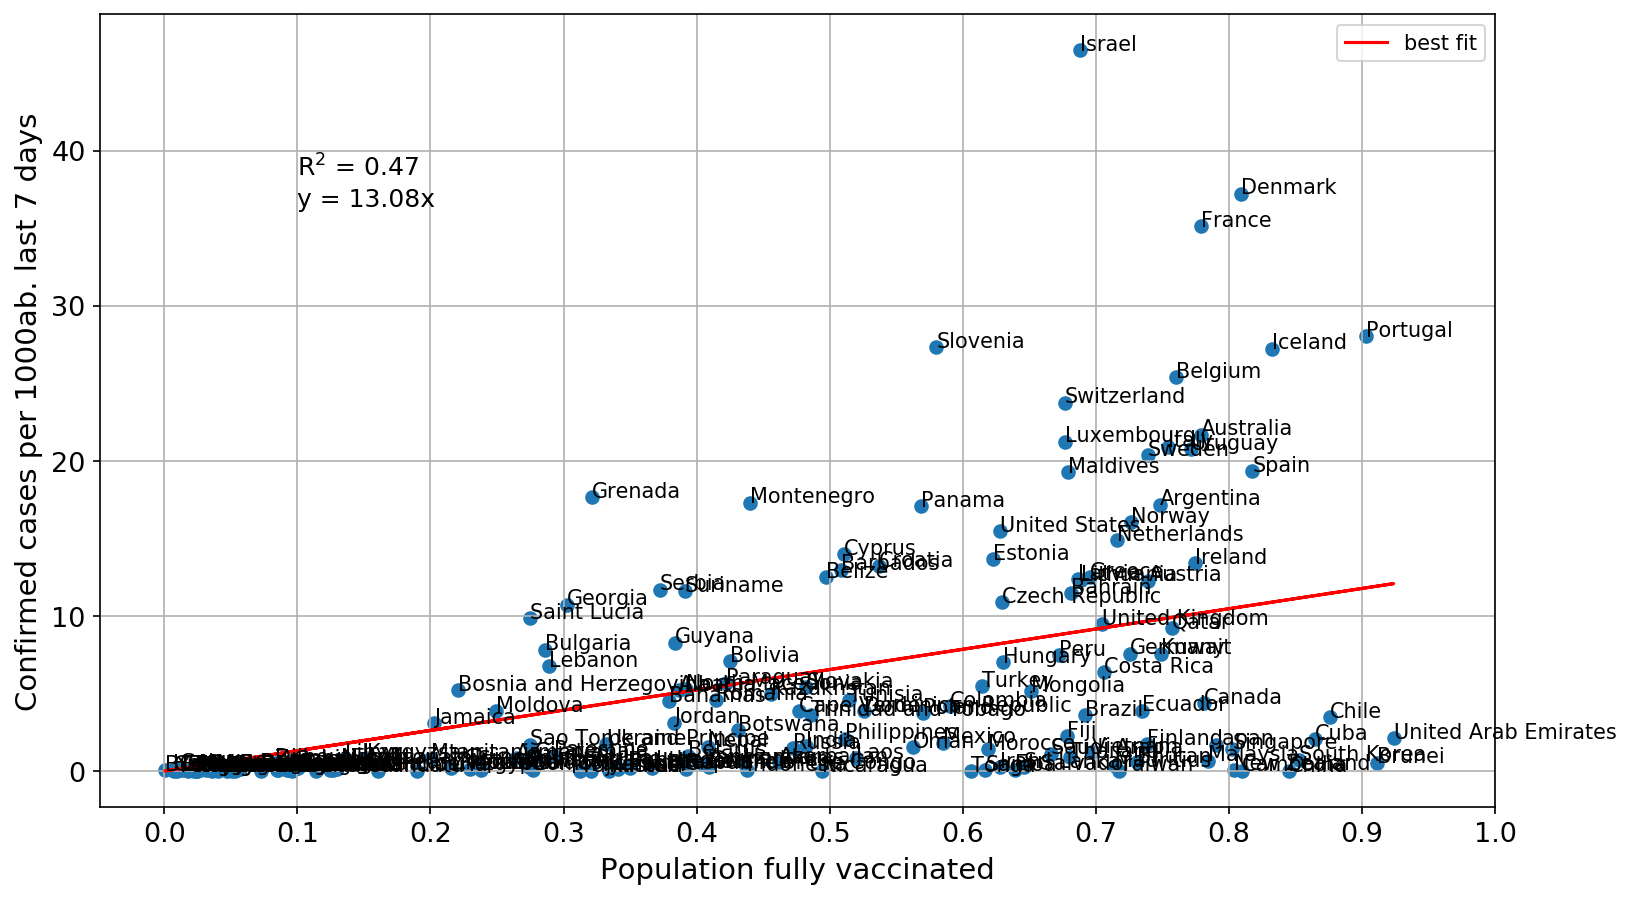

In [18]:
get_scatter_with_fit(df_scatt,
                     yname="confirmed_last_7d_1000", 
                     xtitle="Population fully vaccinated",
                     ytitle="Confirmed cases per 1000ab. last 7 days",
                     savename="confirmed_7d_vs_vax.png",
                     text_xpos=0.1)

                                 OLS Regression Results                                 
Dep. Variable:     deaths_last_7d_1000   R-squared (uncentered):                   0.317
Model:                             OLS   Adj. R-squared (uncentered):              0.313
Method:                  Least Squares   F-statistic:                              82.11
Date:                 Fri, 21 Jan 2022   Prob (F-statistic):                    2.37e-16
Time:                         18:02:46   Log-Likelihood:                          463.65
No. Observations:                  178   AIC:                                     -925.3
Df Residuals:                      177   BIC:                                     -922.1
Df Model:                            1                                                  
Covariance Type:             nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------

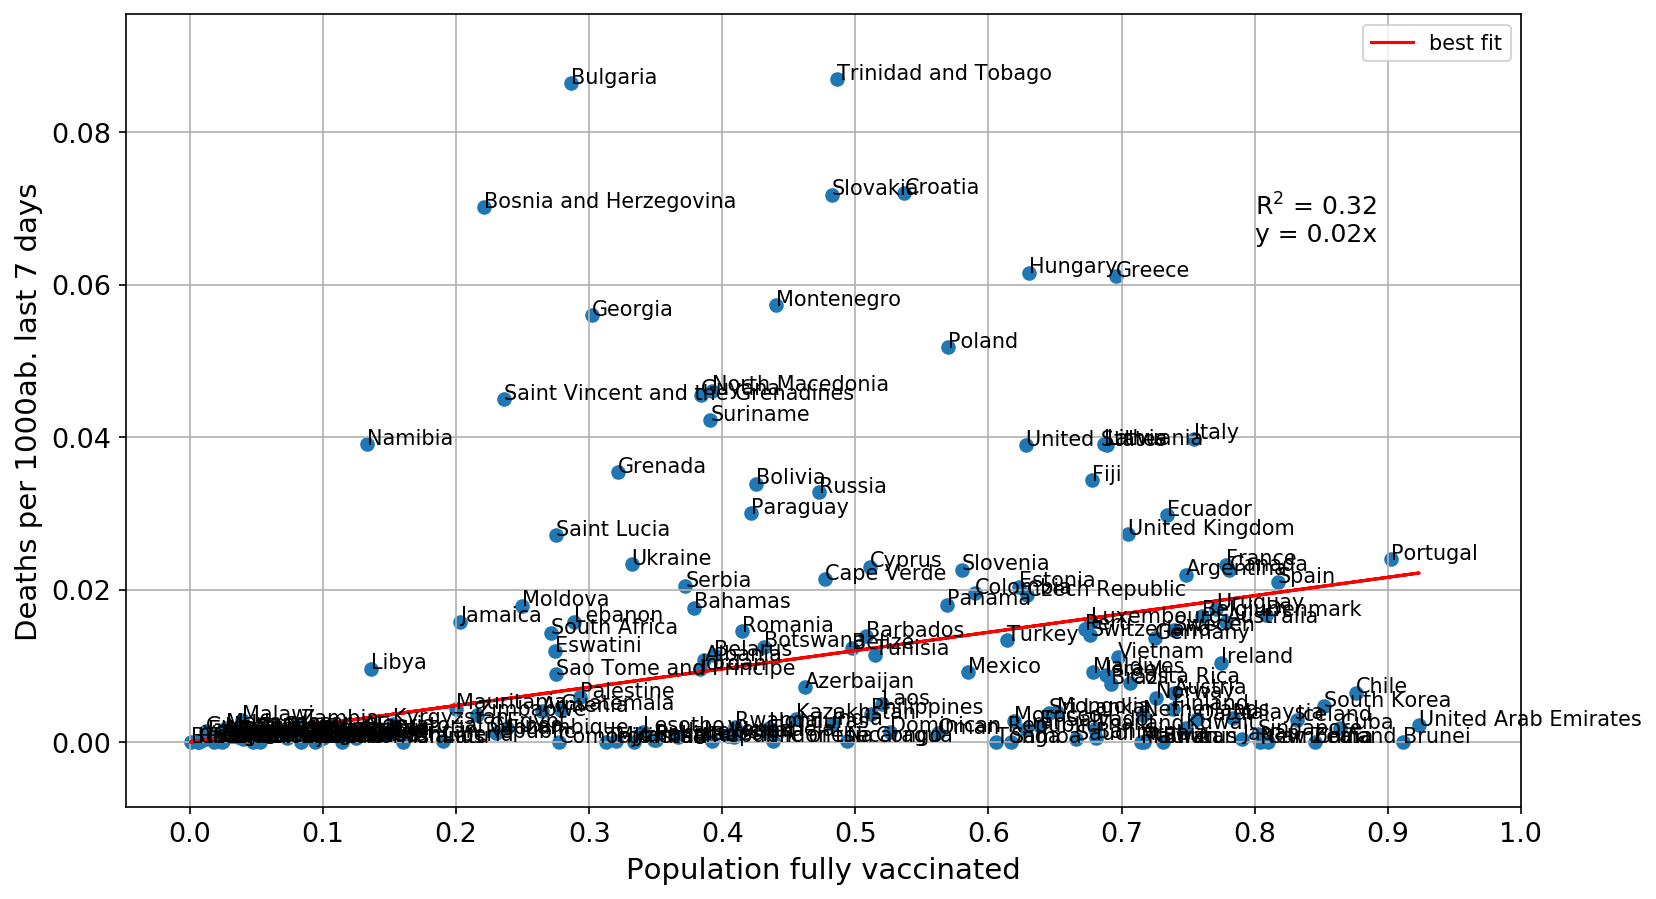

In [19]:
get_scatter_with_fit(df_scatt, 
                     yname="deaths_last_7d_1000", 
                     ytitle="Deaths per 1000ab. last 7 days",
                     xtitle="Population fully vaccinated",
                     savename="deaths_7d_vs_vax.png",
                     text_xpos=0.8)

In [20]:
def create_YoY_plot(df,
                    country: str,
                    varname: str,
                    province: str = None,
                    cumulative: bool = False,
                    verbose = False,
                    per_100k: bool = False,
                    std_cutoff=20):
    
    df_plot=df[df.Country==country]
    if not province:
        df_plot = df_plot[df_plot.State==""]
    
    df_plot = df_plot.sort_values(by="Date")
    df_plot["Year"] = pd.to_numeric(df_plot["Date"].dt.year)
    df_plot["DayOfYear"] = pd.to_numeric(df_plot["Date"].dt.dayofyear)
    df_plot["DayOfWeek"] = pd.to_numeric(df_plot["Date"].dt.dayofweek)
    df_plot = df_plot.sort_values(by="Date").reset_index().drop(columns=["index"])
    
    mean_deaths = np.mean(df_plot[varname])
    sd_deaths = np.std(df_plot[varname])
    
    df_plot = df_plot[np.abs(df_plot[varname]) <= mean_deaths + std_cutoff*sd_deaths]
    df_plot = df_plot[df_plot[varname] >= 0]
    df_plot[f"{varname}_7d"] = df_plot[varname].rolling(window=7).mean()

    df_years = {}
    years = df_plot["Year"].unique()
    
    today = datetime.strftime(np.max(df_plot["Date"]),"%Y-%m-%d")

    plt.figure(dpi=150, figsize=(8,4))
    colors = plt.get_cmap("tab10")
    idx = 0
    for year in sorted(years):
        denominator = 1
        
        dfy = df_plot[df_plot["Year"]==year].sort_values(by="DayOfYear")
        dfy[f"{varname}_cum"] = dfy[varname].cumsum()
        if per_100k:
            denominator = dfy["pop2021"]
        if cumulative: 
            plt.plot(dfy["DayOfYear"], dfy[f"{varname}_cum"]/denominator, label=year, color=colors(idx))
        else:
            plt.plot(dfy["DayOfYear"], dfy[varname]/denominator, alpha=0.3, color=colors(idx))
            plt.plot(dfy["DayOfYear"], dfy[f"{varname}_7d"]/denominator, label=year, color=colors(idx))
        idx += 1
        df_years[year]= dfy
        
    plt.grid()
    plt.xlabel("day of the year", fontsize=14)
    ylabel_txt = f"{varname}"
    filename = f"./plots/yoy_{country}_{varname}"
    if cumulative:
        ylabel_txt = f"cumulative {ylabel_txt}"
        filename += "_cumulative"
    plt.ylabel(ylabel_txt.replace("_"," "), fontsize=14)
    plt_title = f"Country: {country},  Covid19 {varname}"
    if province:
        plt_title += f", {province}"
        filename += f"_{province}"
    filename += ".png"
    plt_title += f",  {today}"
    plt.title(plt_title.replace("_"," "), fontsize=14)
    plt.legend()
    plt.savefig(filename, bbox_inches="tight")
    return df_years

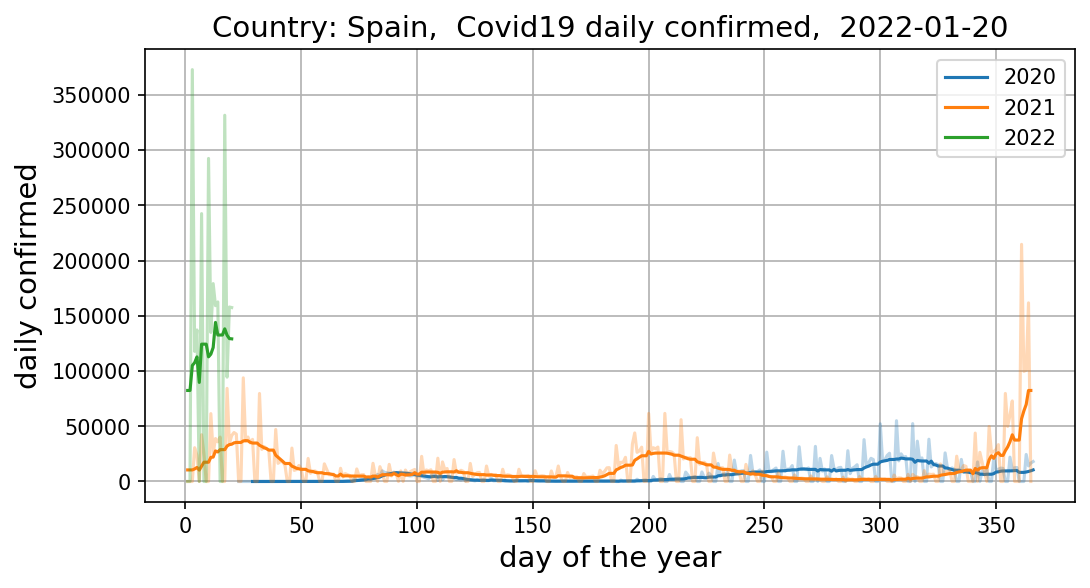

In [21]:
_ = create_YoY_plot(df, 
                    country="Spain", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

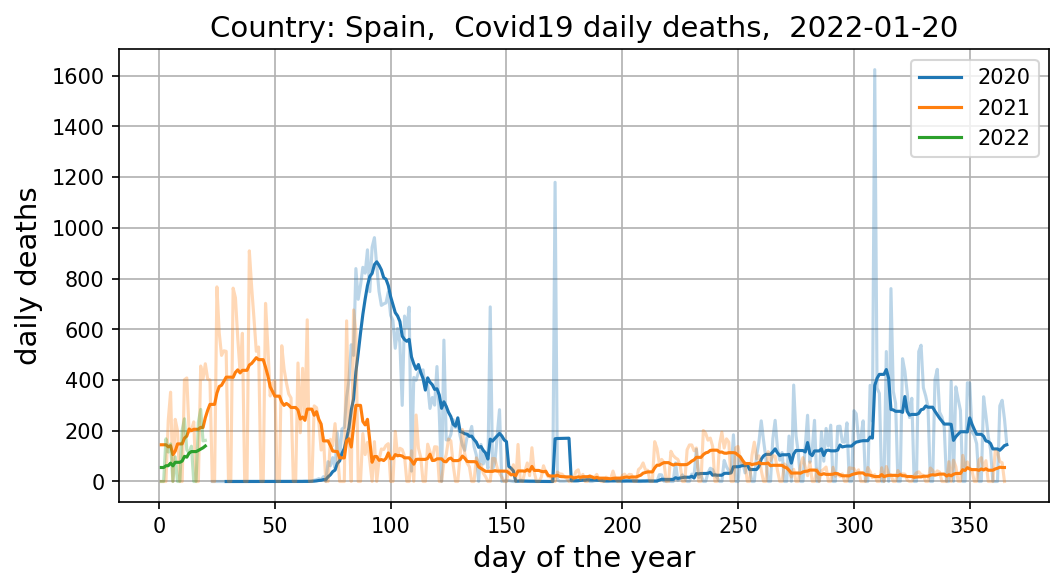

In [22]:
_ = create_YoY_plot(df, 
                    country="Spain", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

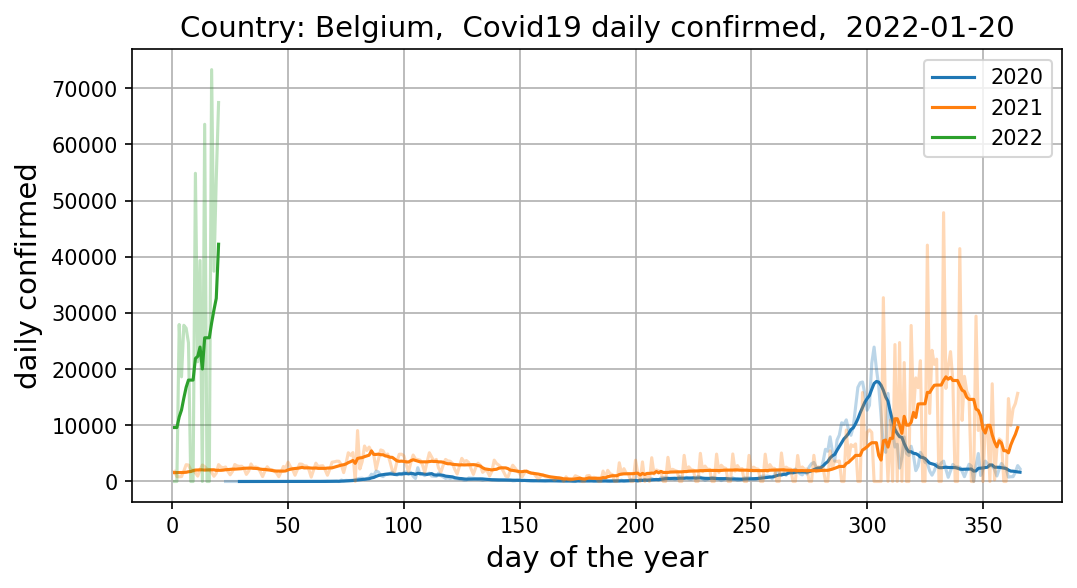

In [23]:
_ = create_YoY_plot(df, 
                    country="Belgium", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

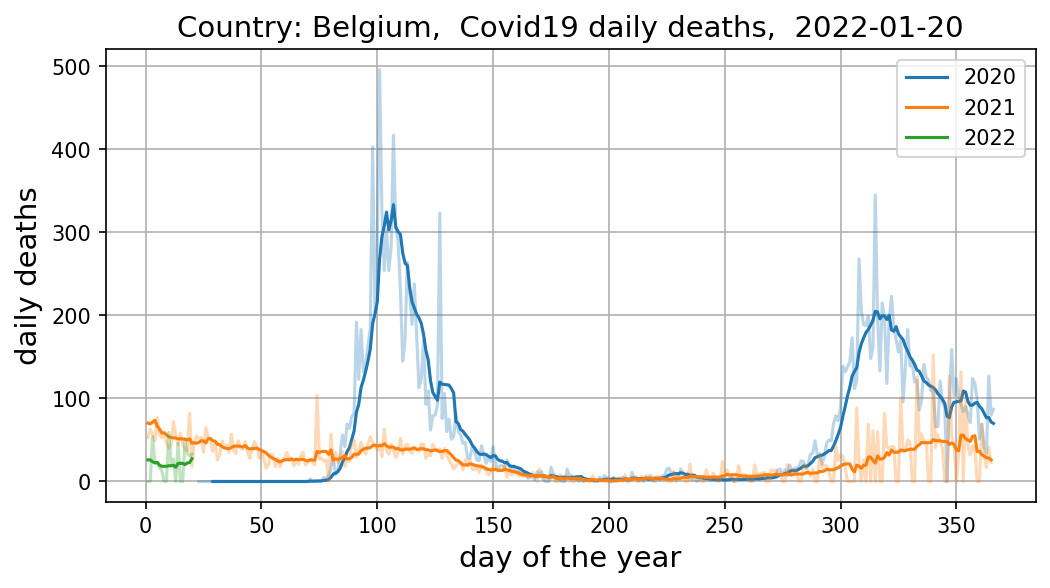

In [24]:
_ = create_YoY_plot(df, 
                    country="Belgium", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

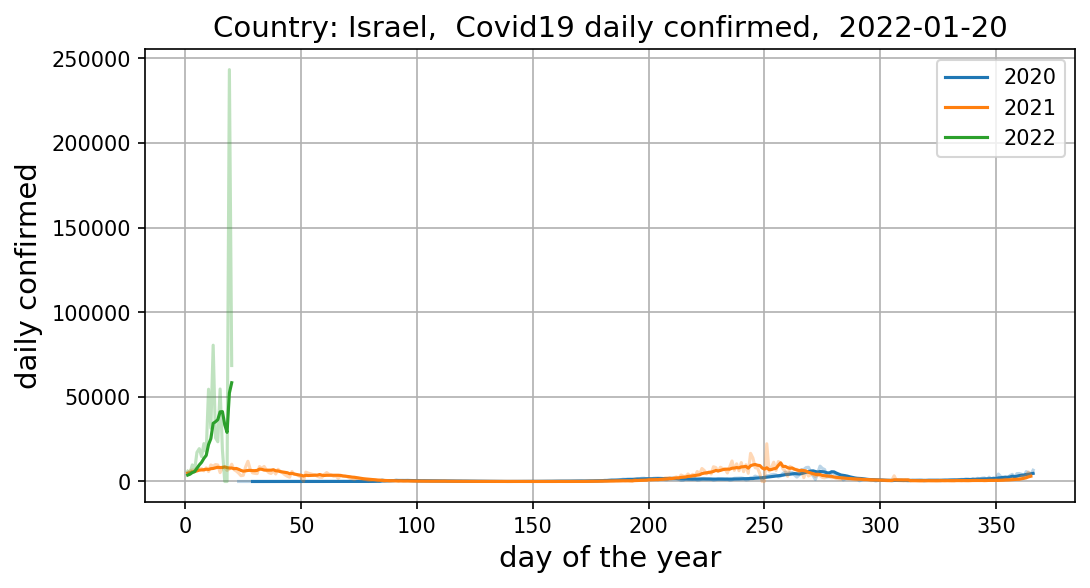

In [25]:
_ = create_YoY_plot(df, 
                    country="Israel", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

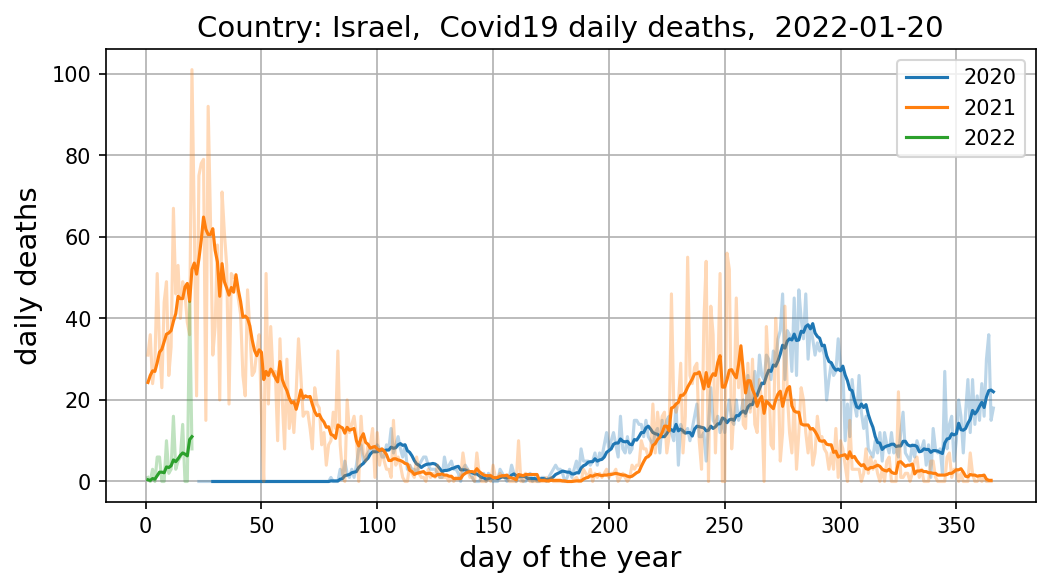

In [26]:
_ = create_YoY_plot(df, 
                    country="Israel", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

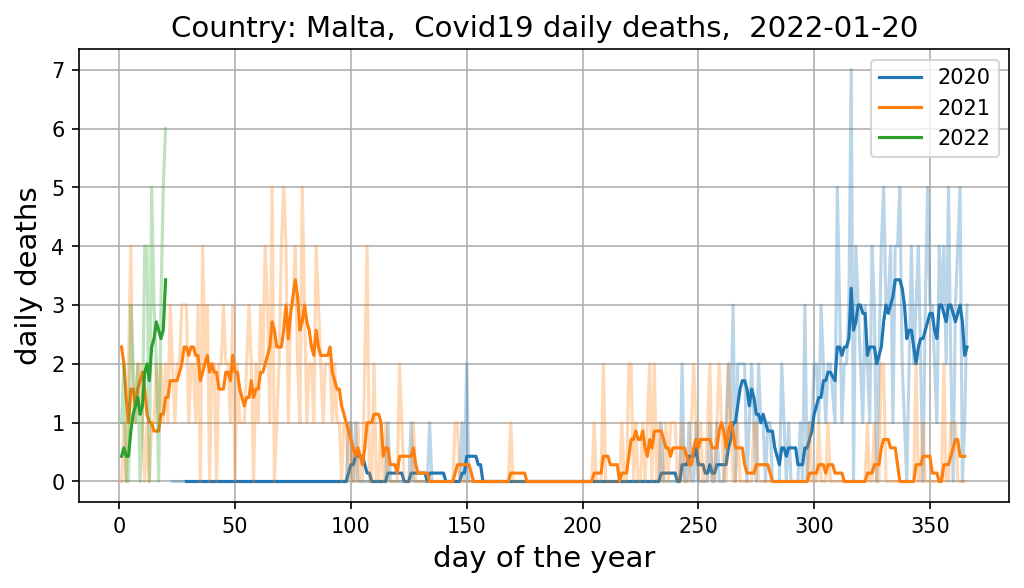

In [27]:
_ = create_YoY_plot(df, 
                    country="Malta", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

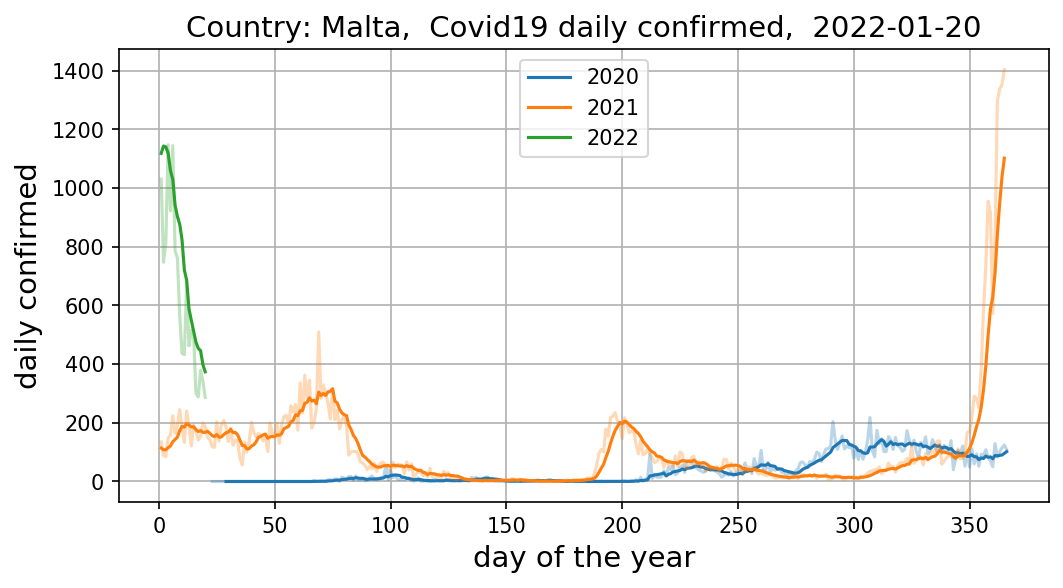

In [28]:
_ = create_YoY_plot(df, 
                    country="Malta", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

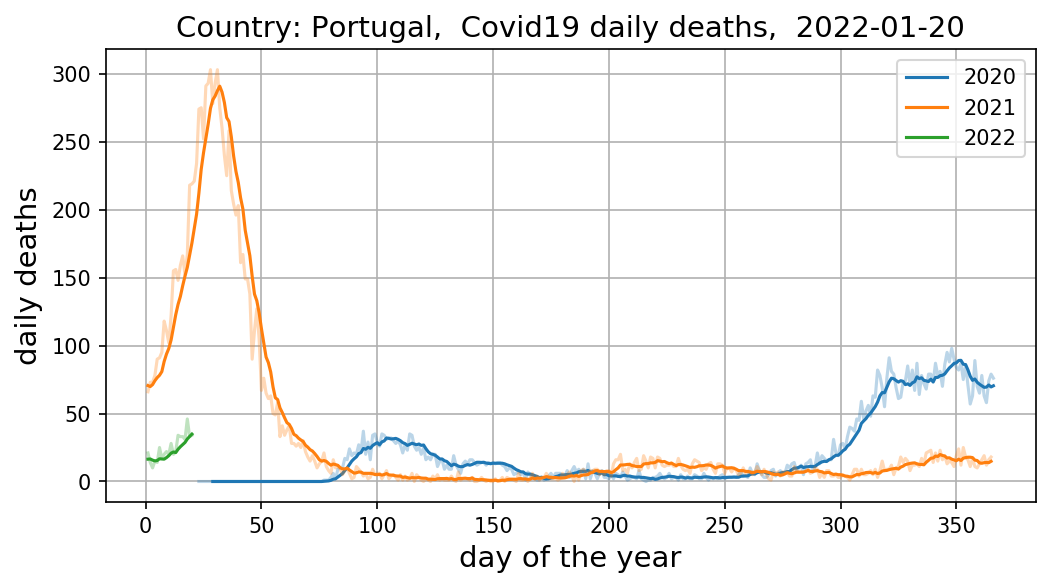

In [29]:
_ = create_YoY_plot(df, 
                    country="Portugal", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

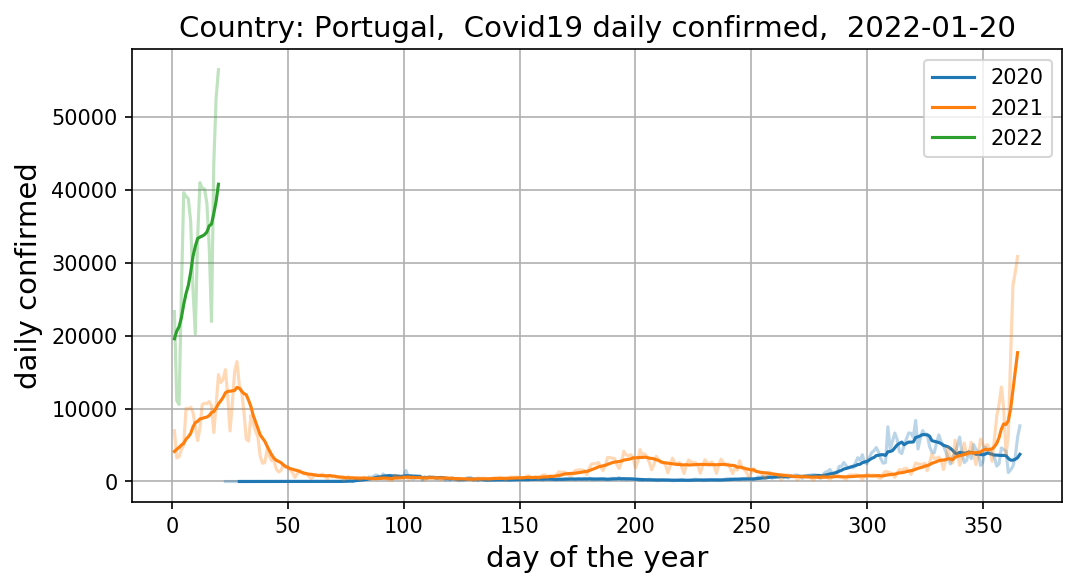

In [30]:
_ = create_YoY_plot(df, 
                    country="Portugal", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

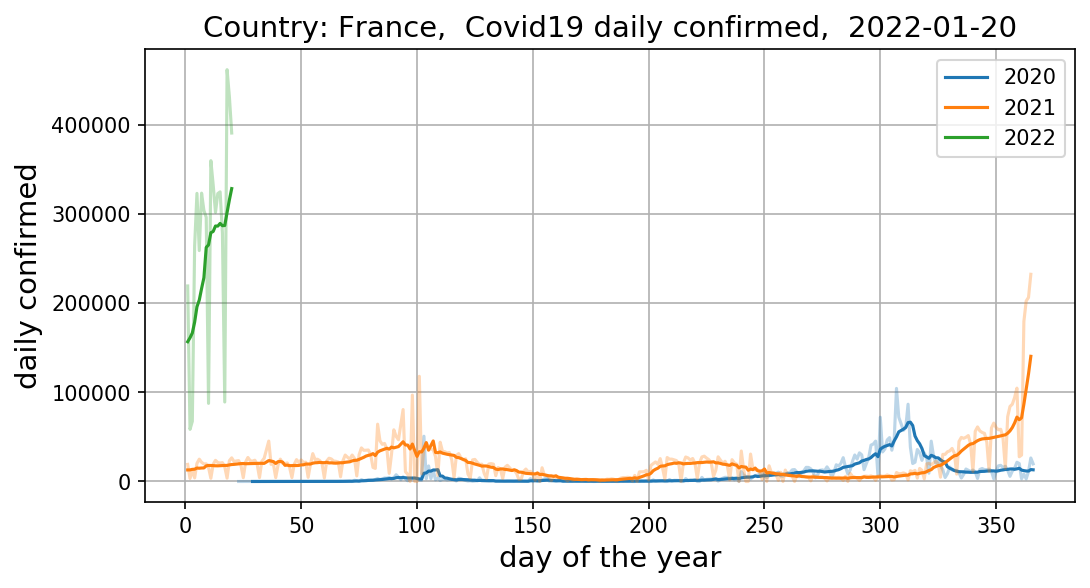

In [31]:
df_france = create_YoY_plot(df, 
                    country="France", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

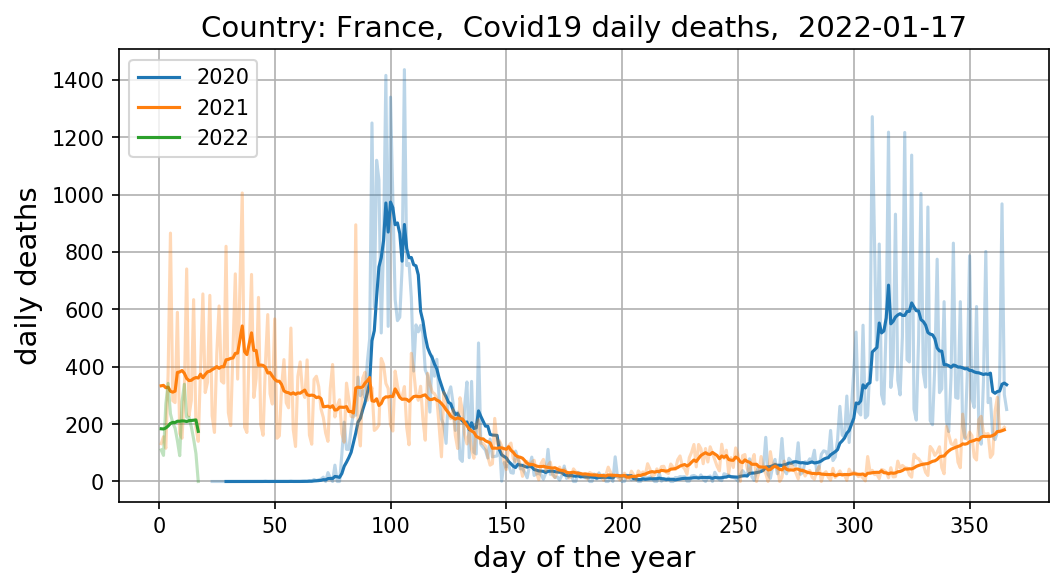

In [32]:
df_france = create_YoY_plot(df, 
                    country="France", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

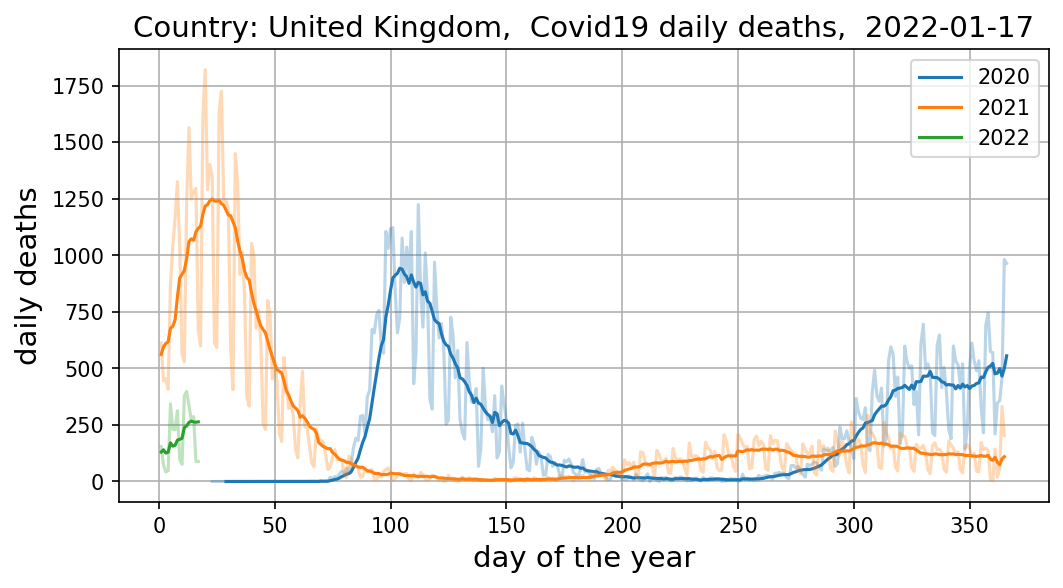

In [33]:
 _ = create_YoY_plot(df, 
                    country="United Kingdom", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

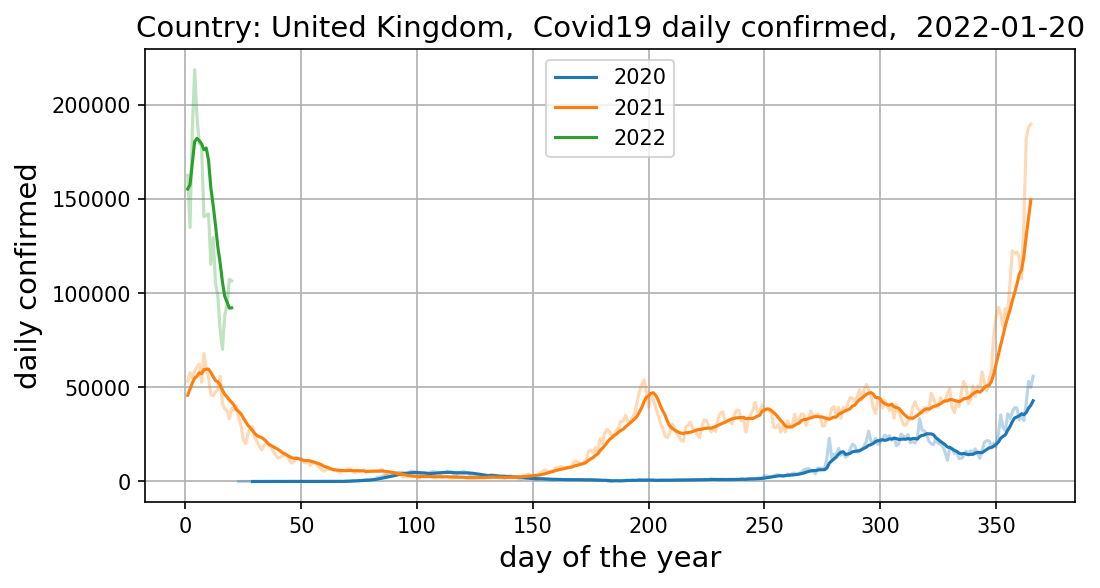

In [32]:
 _ = create_YoY_plot(df, 
                    country="United Kingdom", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

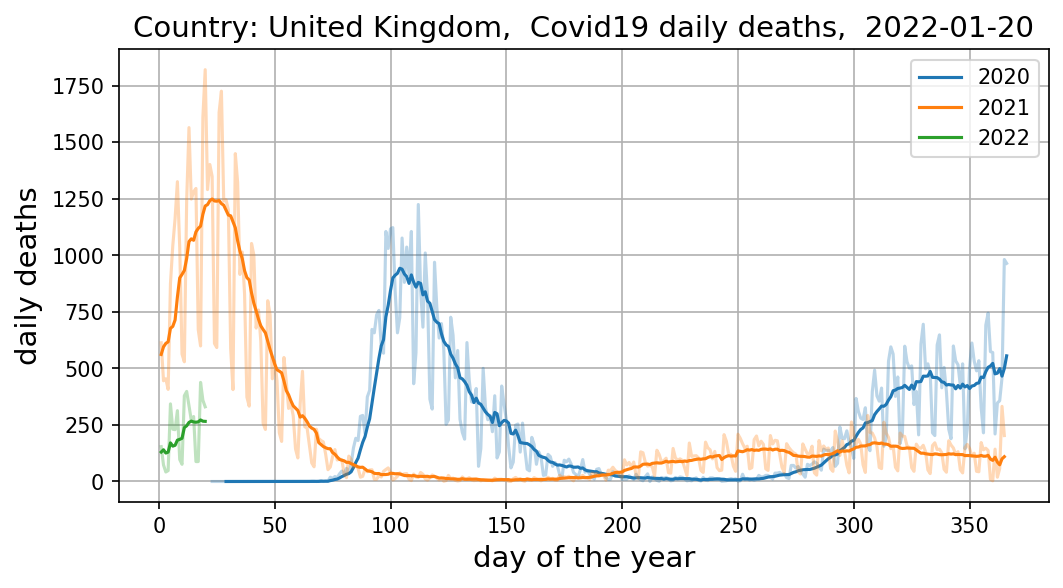

In [33]:
 _ = create_YoY_plot(df, 
                    country="United Kingdom", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

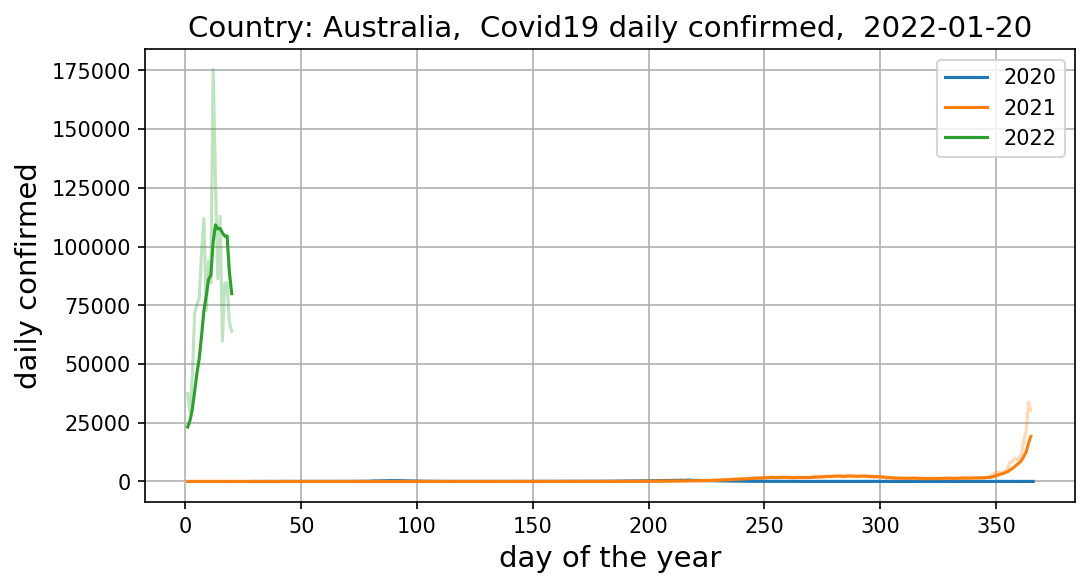

In [34]:
_ = create_YoY_plot(df, 
                    country="Australia", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

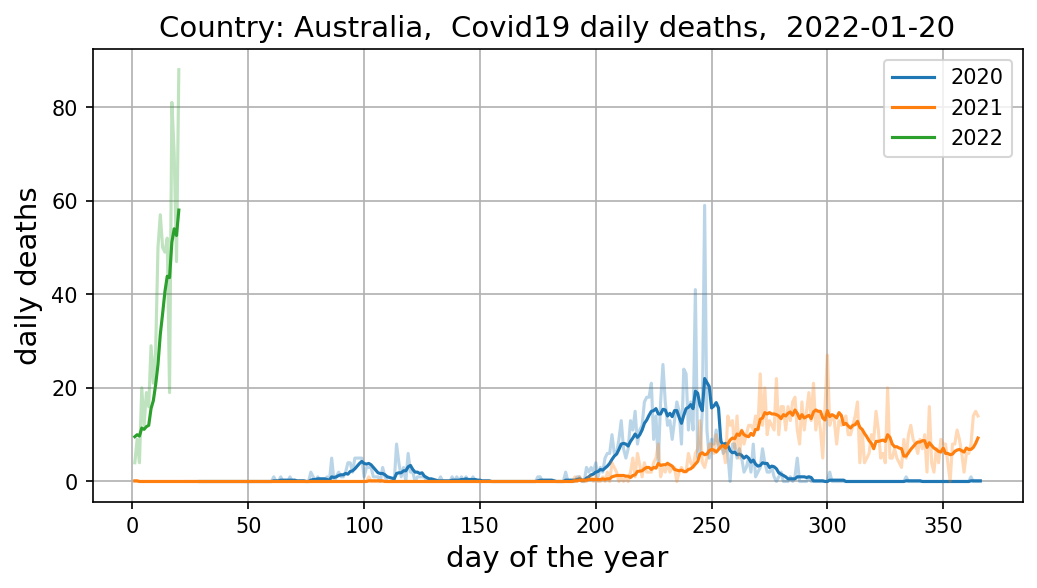

In [35]:
_ = create_YoY_plot(df, 
                    country="Australia", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

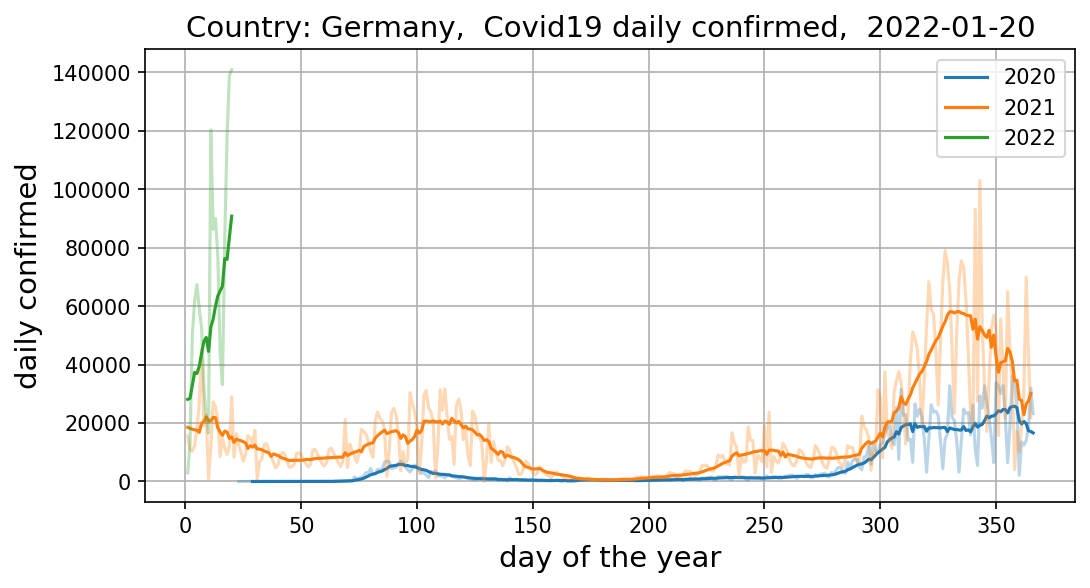

In [36]:
_ = create_YoY_plot(df, 
                    country="Germany", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

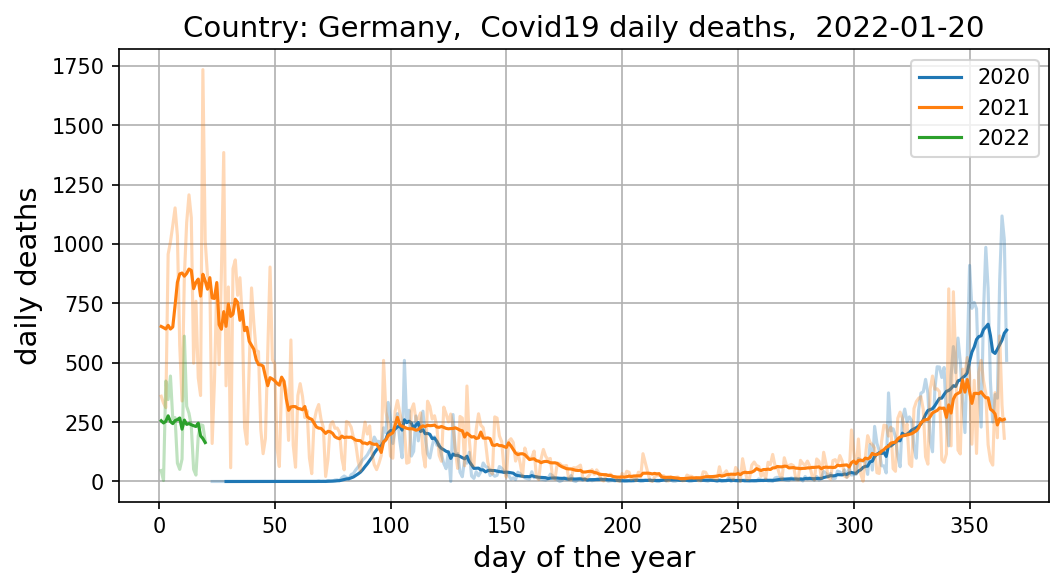

In [37]:
df_germany = create_YoY_plot(df, 
                    country="Germany", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

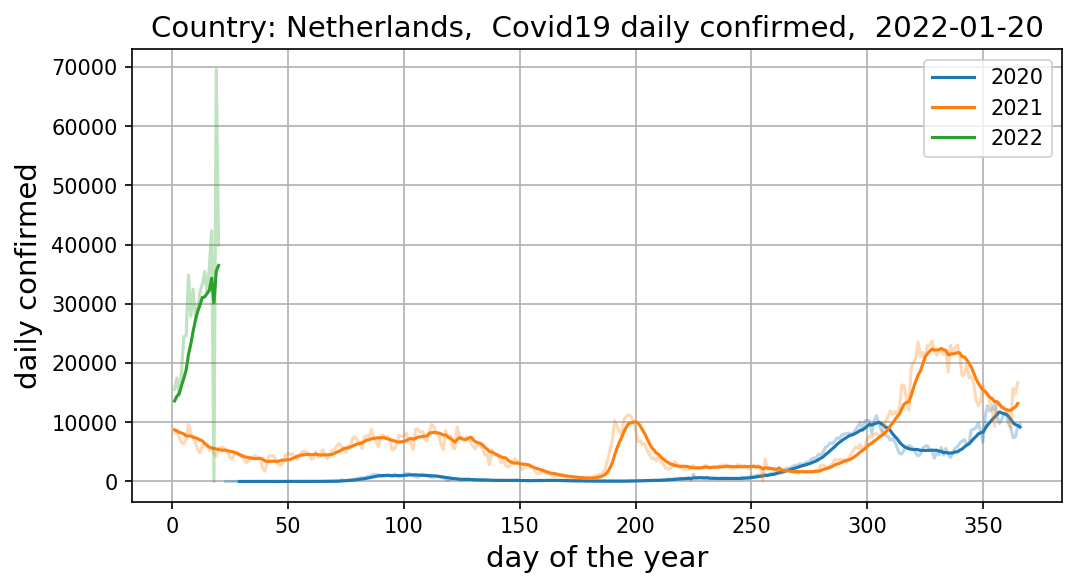

In [38]:
_ = create_YoY_plot(df, 
                    country="Netherlands", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

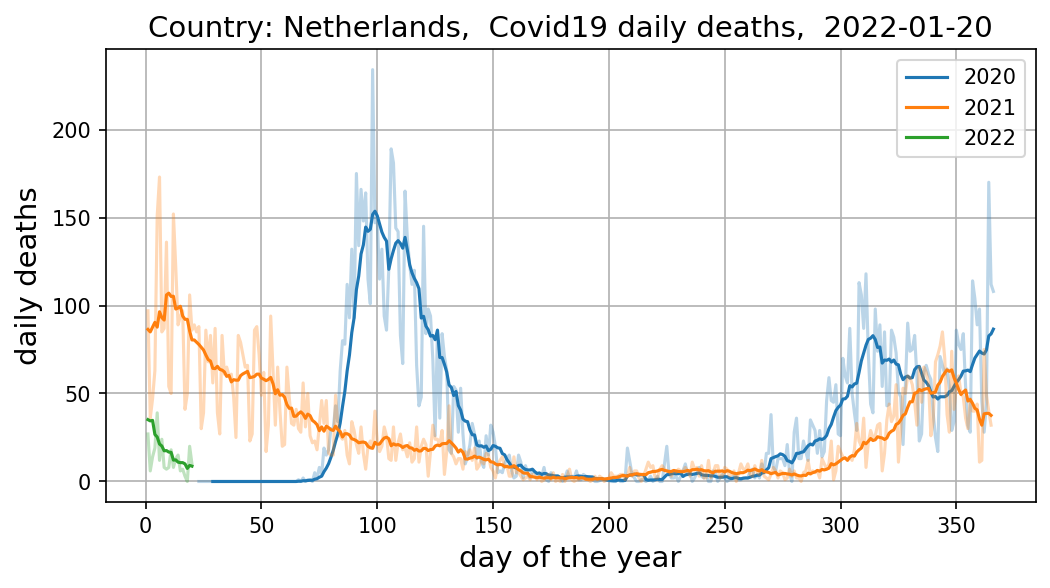

In [39]:
_ = create_YoY_plot(df, 
                    country="Netherlands", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

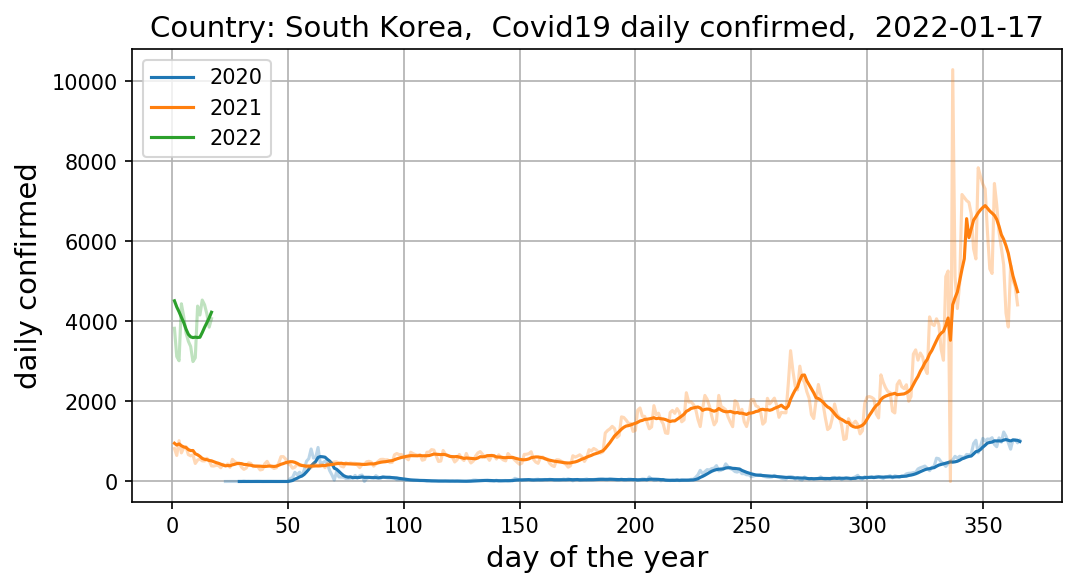

In [42]:
_ = create_YoY_plot(df, 
                    country="South Korea", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

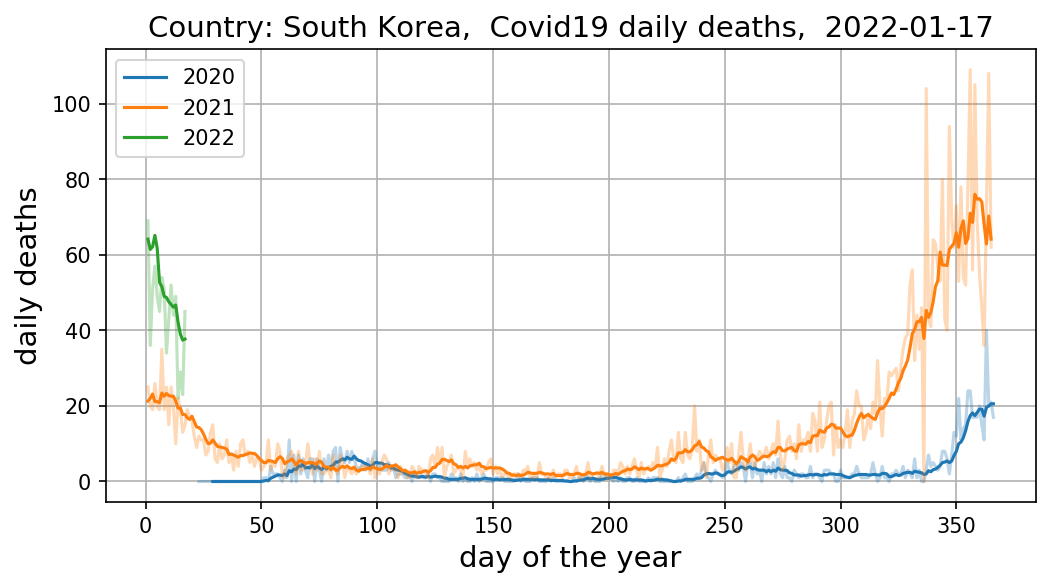

In [43]:
_ = create_YoY_plot(df, 
                    country="South Korea", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

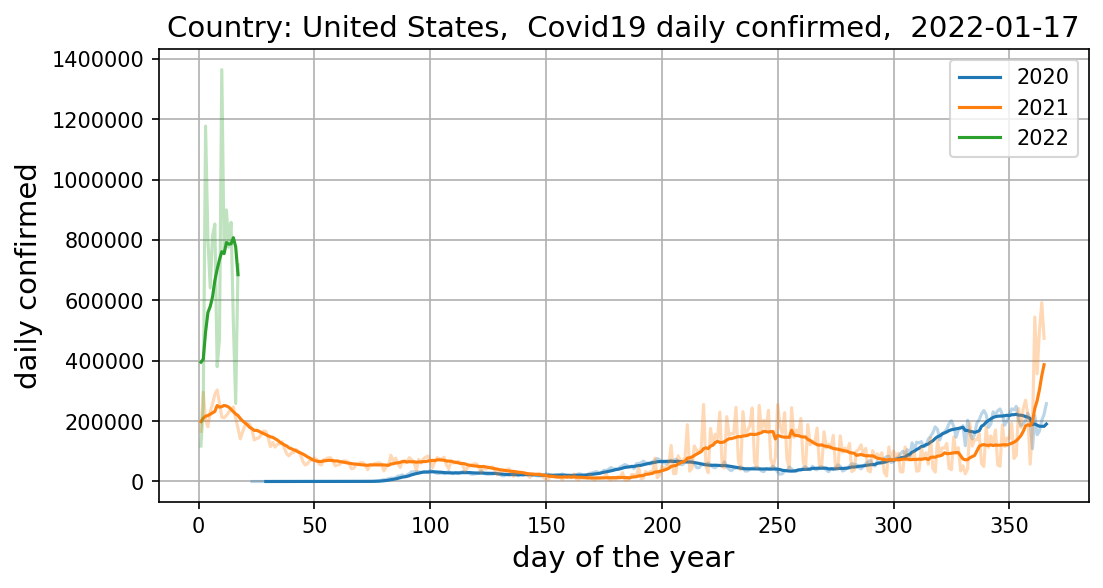

In [46]:
_ = create_YoY_plot(df, 
                    country="United States", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

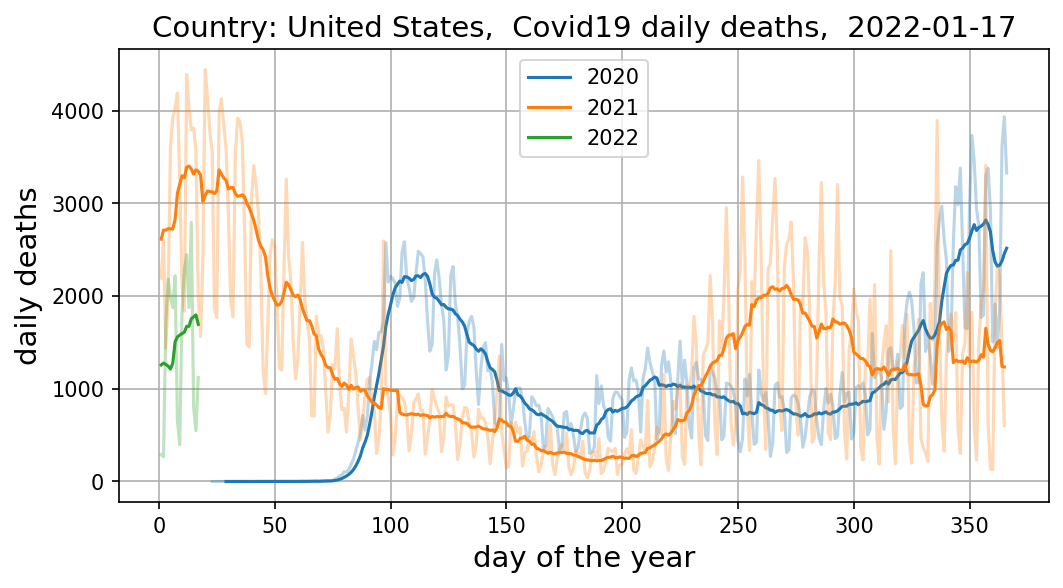

In [47]:
_ = create_YoY_plot(df, 
                    country="United States", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

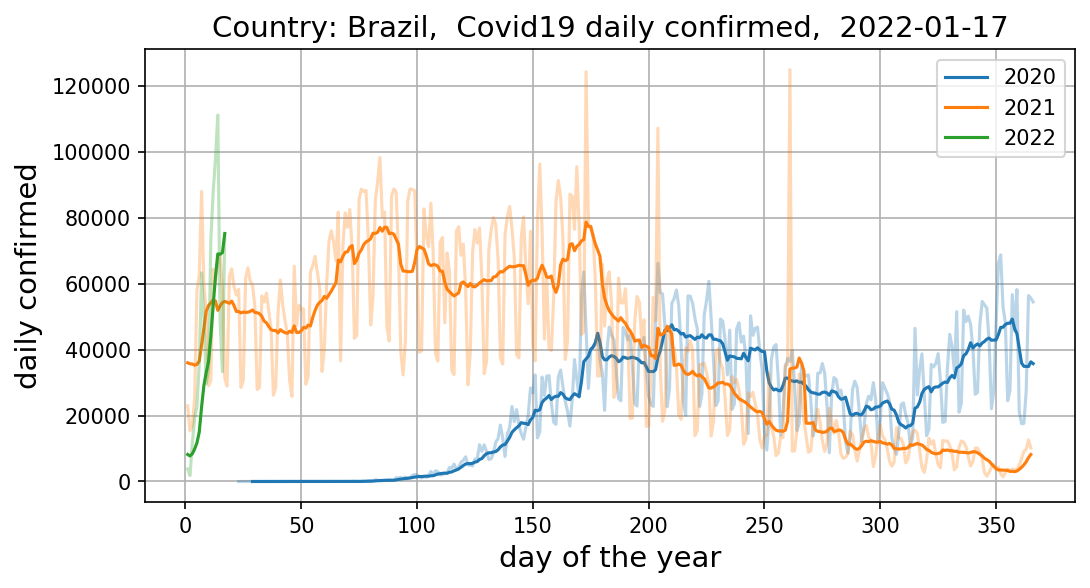

In [48]:
_ = create_YoY_plot(df, 
                    country="Brazil", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

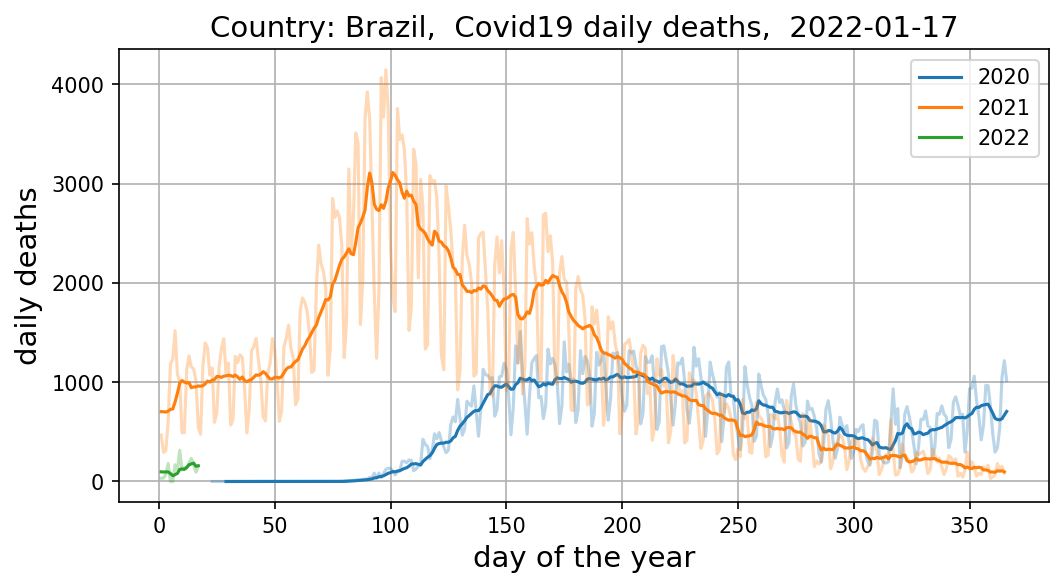

In [49]:
_ = create_YoY_plot(df, 
                    country="Brazil", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

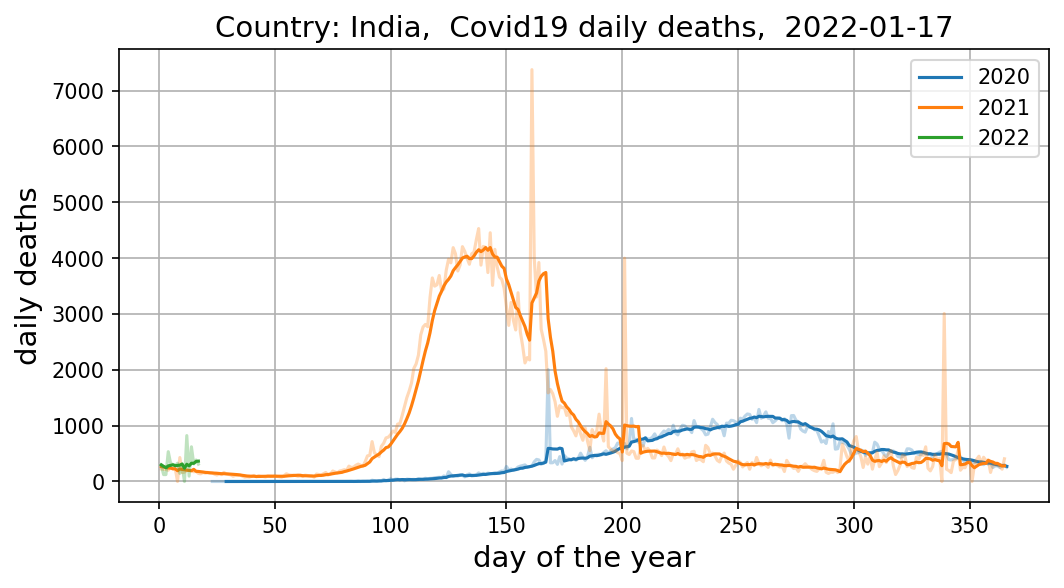

In [50]:
_ = create_YoY_plot(df, 
                    country="India", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

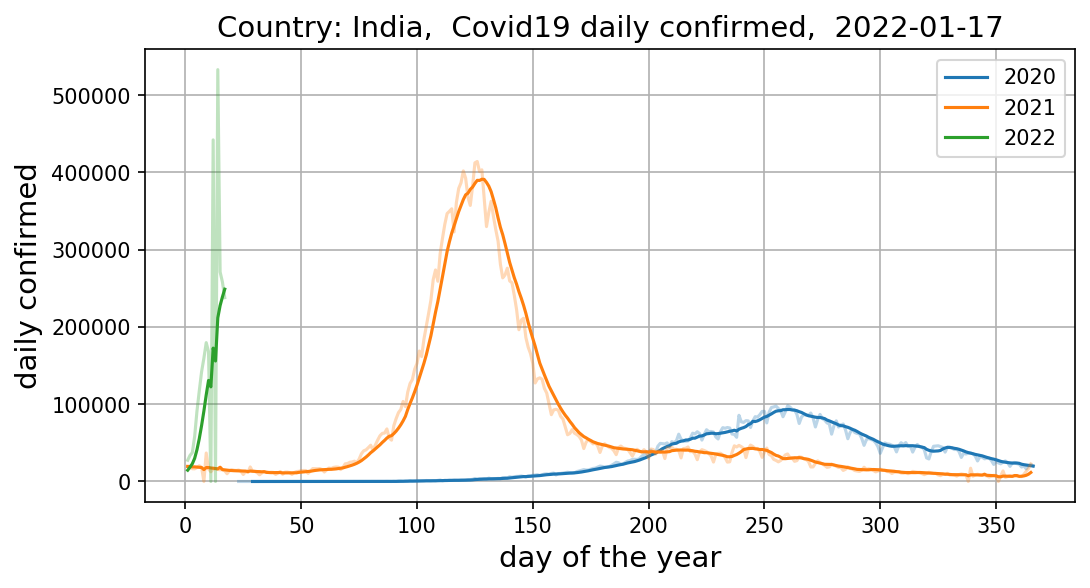

In [51]:
_ = create_YoY_plot(df, 
                    country="India", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

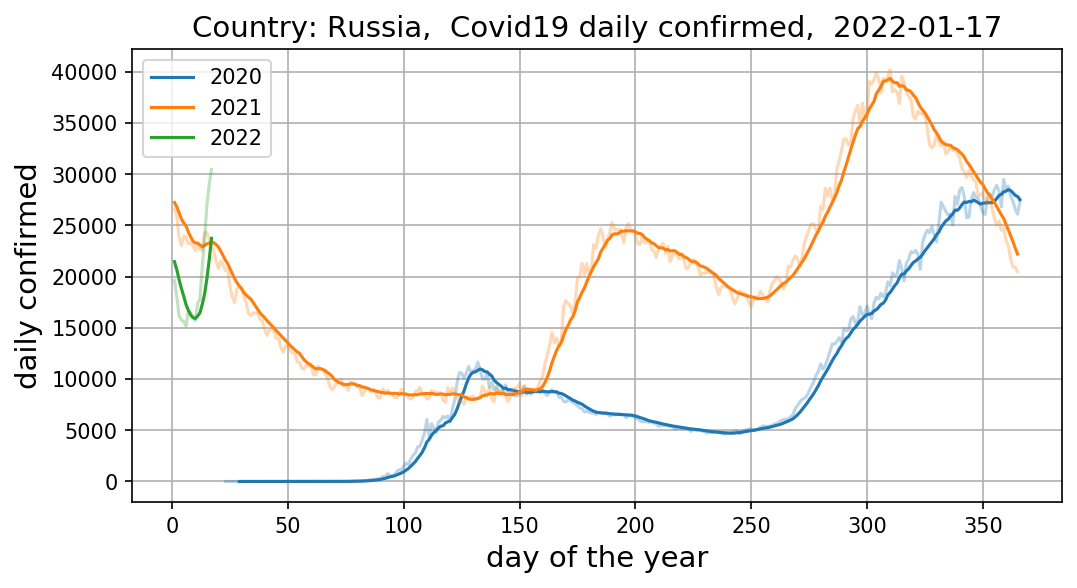

In [52]:
_ = create_YoY_plot(df, 
                    country="Russia", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

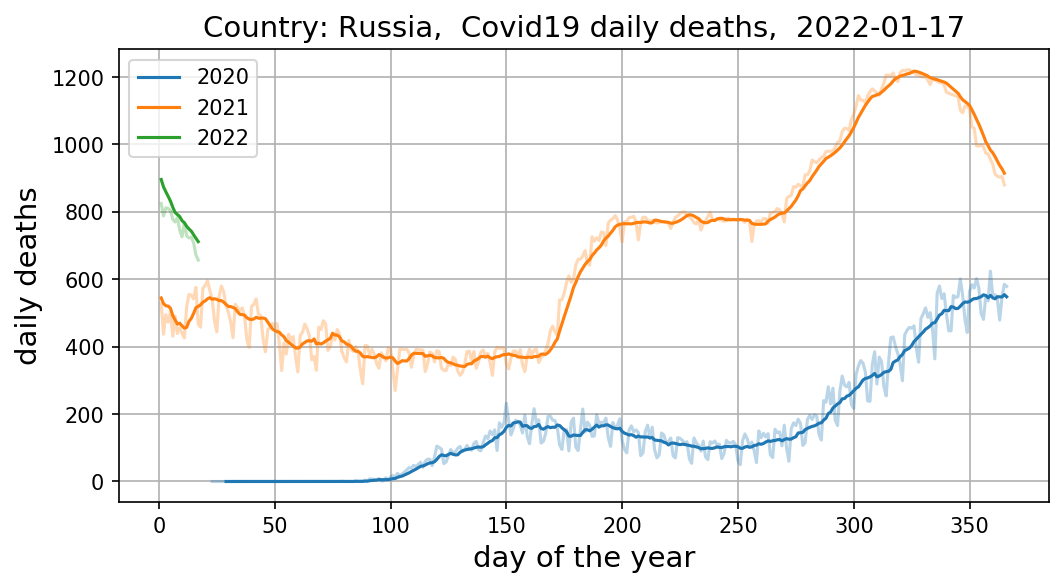

In [53]:
_ = create_YoY_plot(df, 
                    country="Russia", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

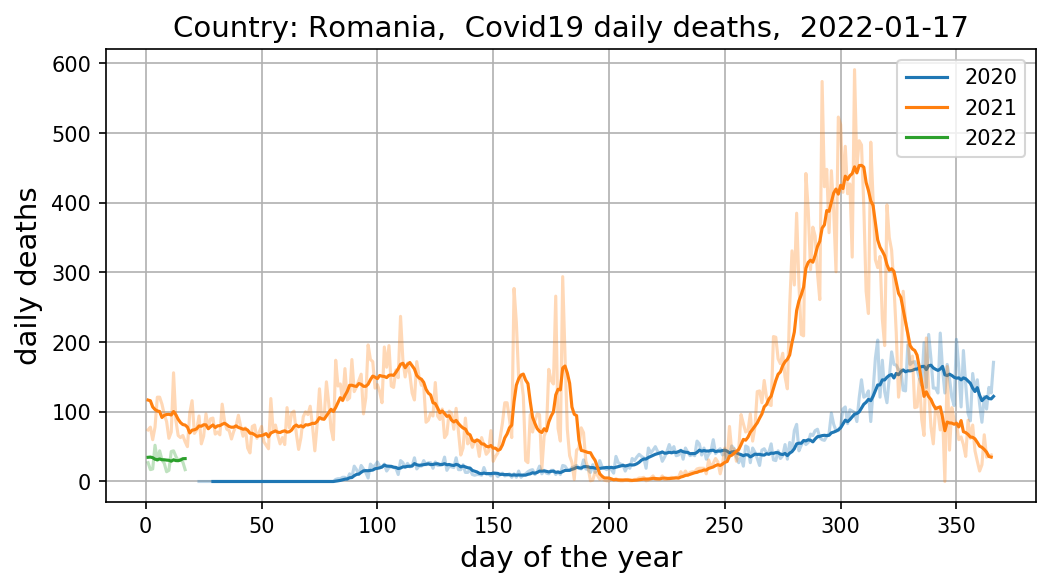

In [54]:
_ = create_YoY_plot(df, 
                    country="Romania", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

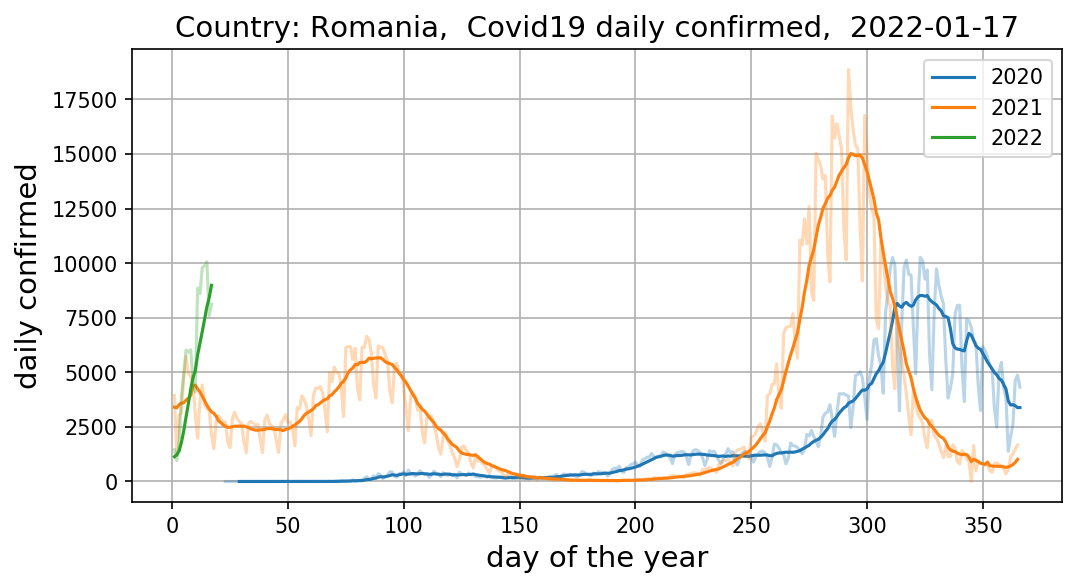

In [55]:
_ = create_YoY_plot(df, 
                    country="Romania", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

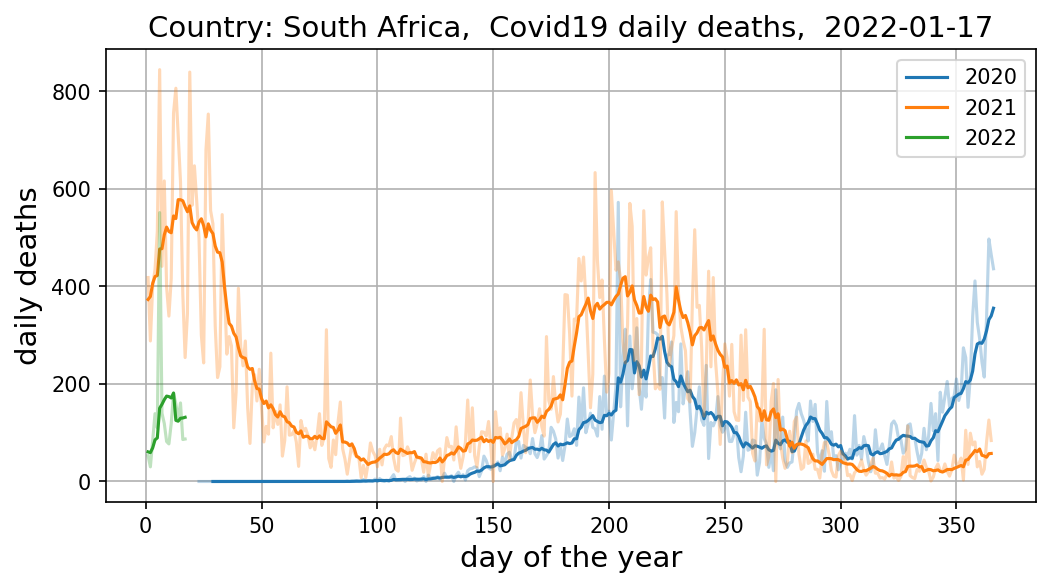

In [57]:
_ = create_YoY_plot(df, 
                    country="South Africa", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

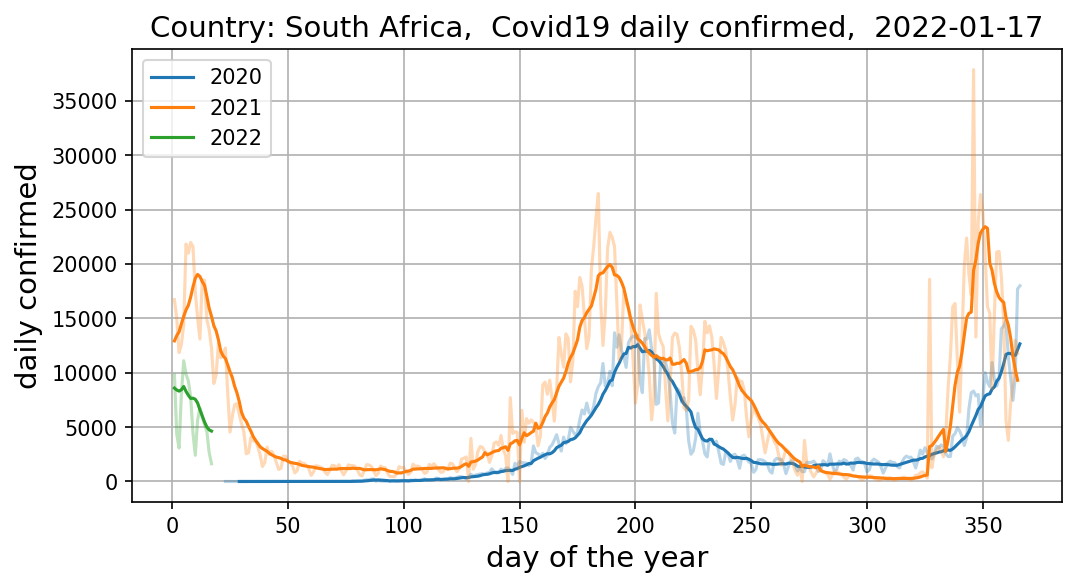

In [58]:
_ = create_YoY_plot(df, 
                    country="South Africa", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

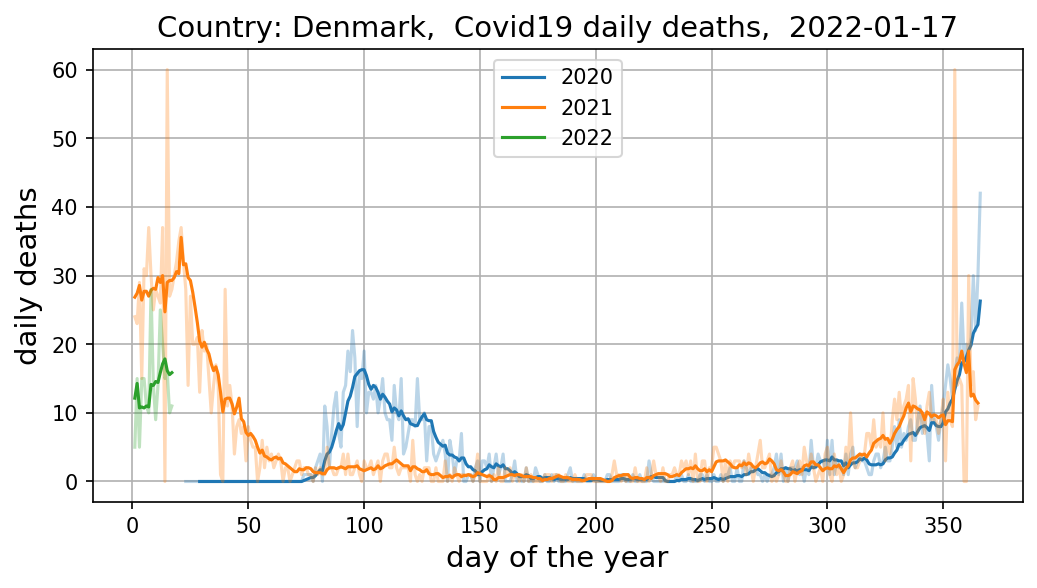

In [59]:
_ = create_YoY_plot(df, 
                    country="Denmark", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

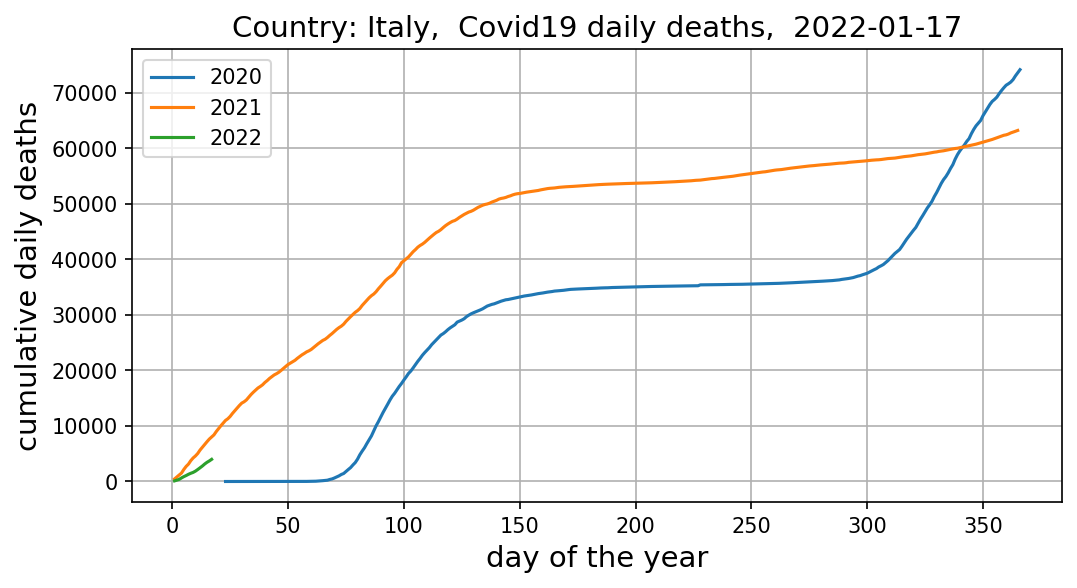

In [60]:
_ = create_YoY_plot(df, 
                    country="Italy", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=True,
                    std_cutoff=10)

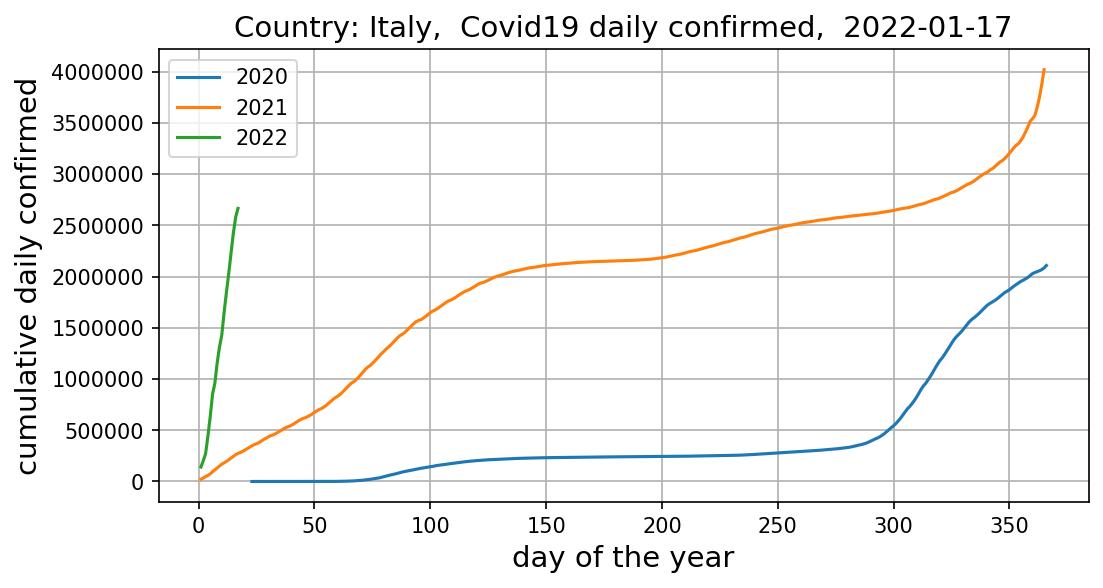

In [61]:
_ = create_YoY_plot(df, 
                    country="Italy", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=True,
                    std_cutoff=10)

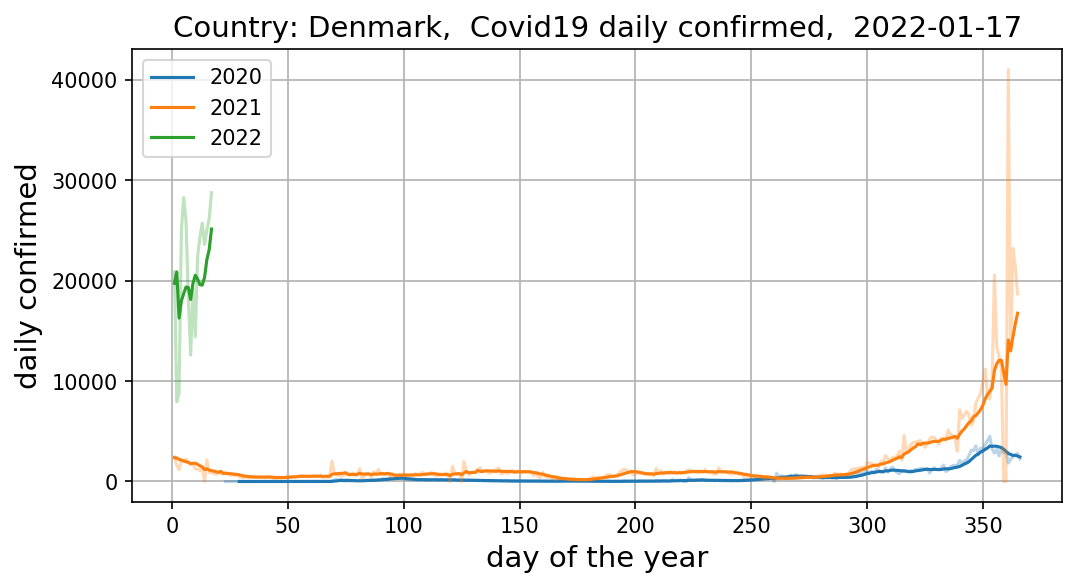

In [62]:
_ = create_YoY_plot(df, 
                    country="Denmark", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

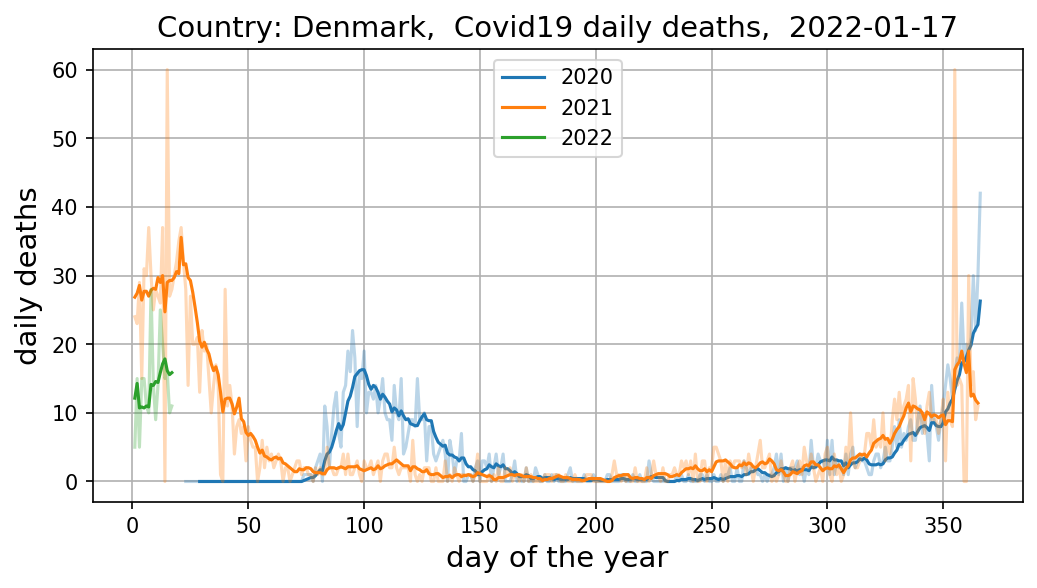

In [63]:
_ = create_YoY_plot(df, 
                    country="Denmark", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

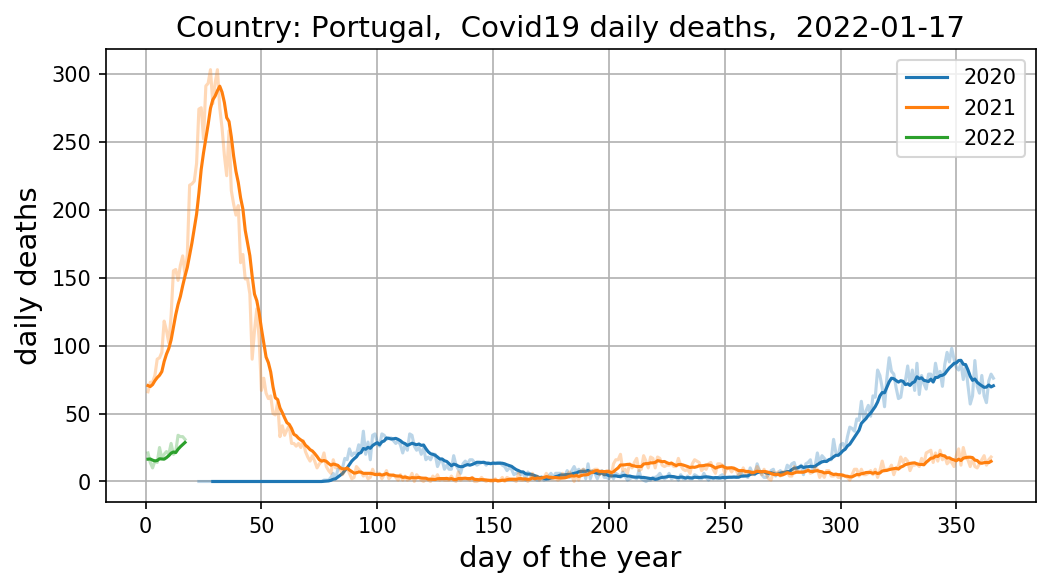

In [64]:
_ = create_YoY_plot(df, 
                    country="Portugal", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

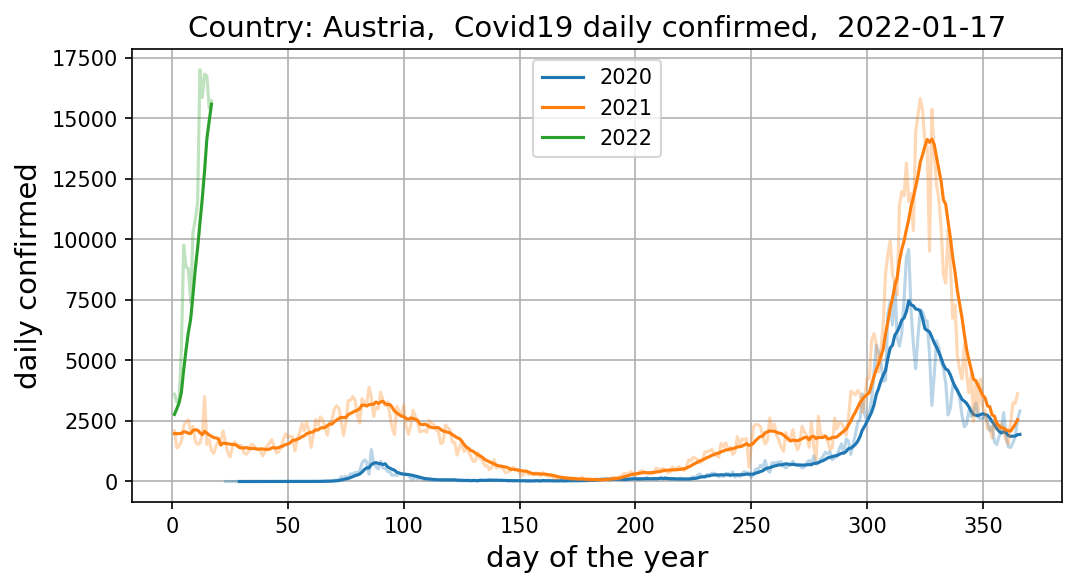

In [65]:
_ = create_YoY_plot(df, 
                    country="Austria", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

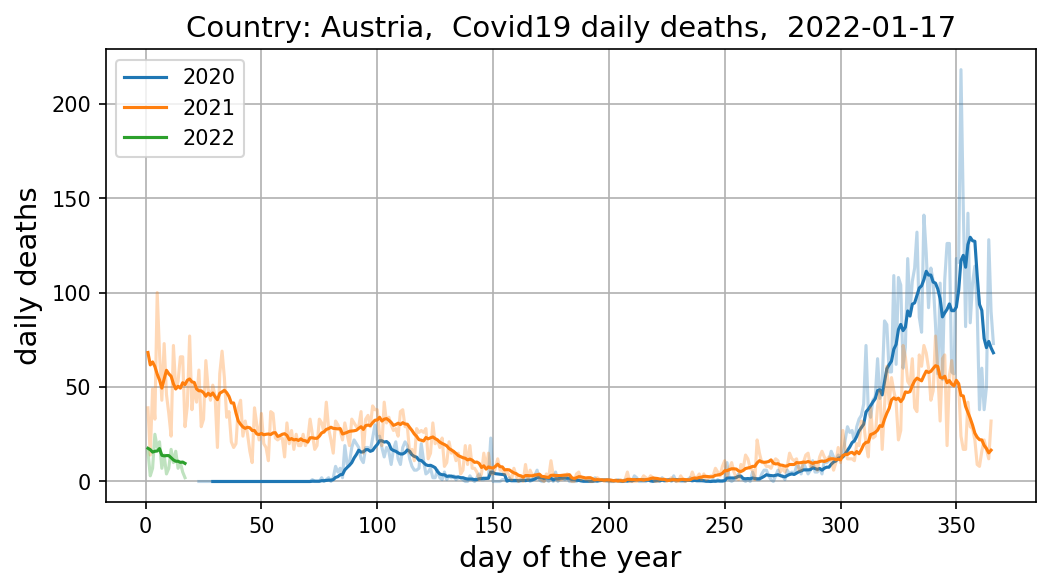

In [66]:
_ = create_YoY_plot(df, 
                    country="Austria", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

In [67]:
df.columns

Index(['Country', 'State', 'Date', 'confirmed', 'deaths', 'pop2020', 'pop2021',
       'confirmed_1000', 'daily_confirmed', 'daily_confirmed_1000',
       'daily_confirmed_mean_7d_1000', 'confirmed_last_7d',
       'confirmed_last_7d_1000', 'deaths_1000', 'daily_deaths',
       'daily_deaths_1000', 'daily_deaths_mean_7d_1000', 'deaths_last_7d',
       'deaths_last_7d_1000', 'people_fully_vaccinated',
       'pop_fully_vaccinated'],
      dtype='object')

In [68]:
def plot_per_million(df,
                     varname, 
                     country_list, 
                     logscale = False,
                     title: str = None,
                     xtitle: str = None,
                     ytitle: str = None,
                     start_date: str = None,
                     country_col_name = "Country",
                     figsize_x = 12,
                     figsize_y = 6,
                     suffix: str = ""
                    ):
    
    if start_date:
        df = df[df["Date"] >= start_date]
    dates =  df["Date"].unique()
    xlabels = [dates[i] for i in range(0,len(dates)) if i % 28 == 0]
    ax, fig = plt.subplots(dpi=160, figsize=(figsize_x,figsize_y))
    
    last_date = np.max(df["Date"])
    print(f"Last date: {last_date}")
    
    for country in country_list:
        df_plot = df[(df[country_col_name]==country) & (df["State"]=="")]
        plt.plot(df_plot["Date"], df_plot[varname],label=country,linewidth=2)
        last_value = df_plot[df_plot["Date"]==last_date][varname]
        plt.annotate(country, xy=(last_date,last_value), xytext=(5,0), textcoords="offset points",
                     color=plt.gca().lines[-1].get_color(),fontsize=11)
    plt.legend(fontsize=12)
    plt.yticks(fontsize=12)
    _=plt.xticks(xlabels, 
               fontsize=12, 
               rotation=50, 
               rotation_mode="anchor", 
               verticalalignment = "top",
               horizontalalignment = "right")
    plt.grid()
    if title:
        plt.title(title,fontsize=16)

    if logscale:
        plt.yscale("log")
        
    plt.ylabel(ytitle,fontsize=14)
    plt.savefig(f"./plots/{varname}_per_thousand{suffix}.png",bbox_inches="tight")

    


In [69]:
df.columns

Index(['Country', 'State', 'Date', 'confirmed', 'deaths', 'pop2020', 'pop2021',
       'confirmed_1000', 'daily_confirmed', 'daily_confirmed_1000',
       'daily_confirmed_mean_7d_1000', 'confirmed_last_7d',
       'confirmed_last_7d_1000', 'deaths_1000', 'daily_deaths',
       'daily_deaths_1000', 'daily_deaths_mean_7d_1000', 'deaths_last_7d',
       'deaths_last_7d_1000', 'people_fully_vaccinated',
       'pop_fully_vaccinated'],
      dtype='object')

Last date: 2022-01-17 00:00:00


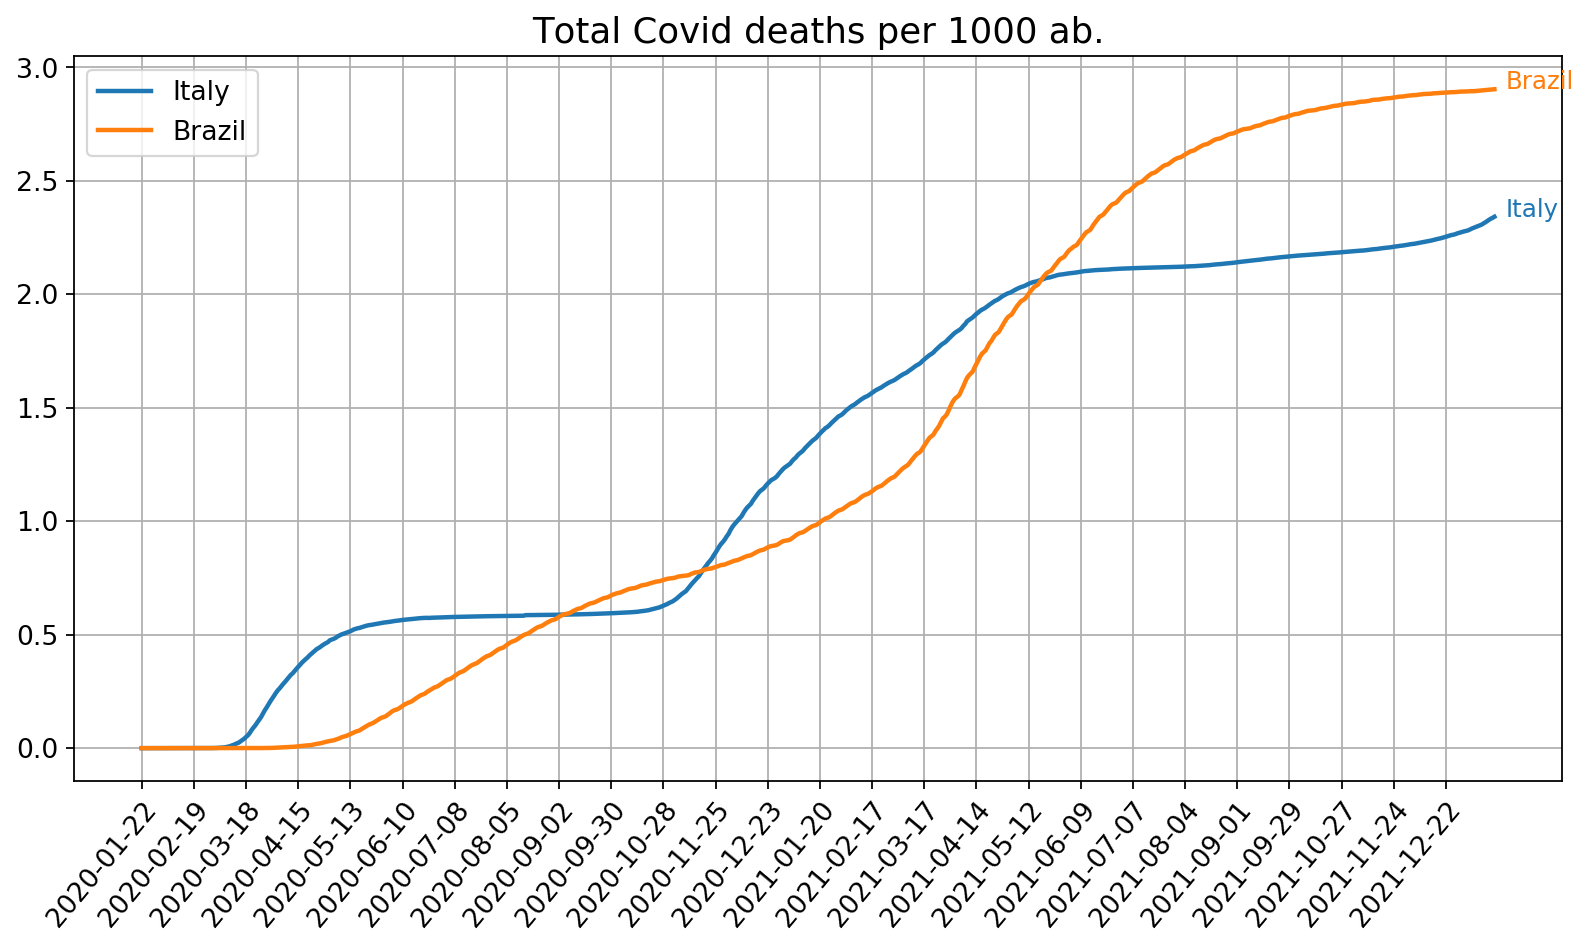

In [72]:
plot_per_million(df, 
                 varname="deaths_1000", 
                 country_list=["Italy", "Brazil"],
                 logscale=False,
                 title="Total Covid deaths per 1000 ab."
                )

Last date: 2022-01-17 00:00:00


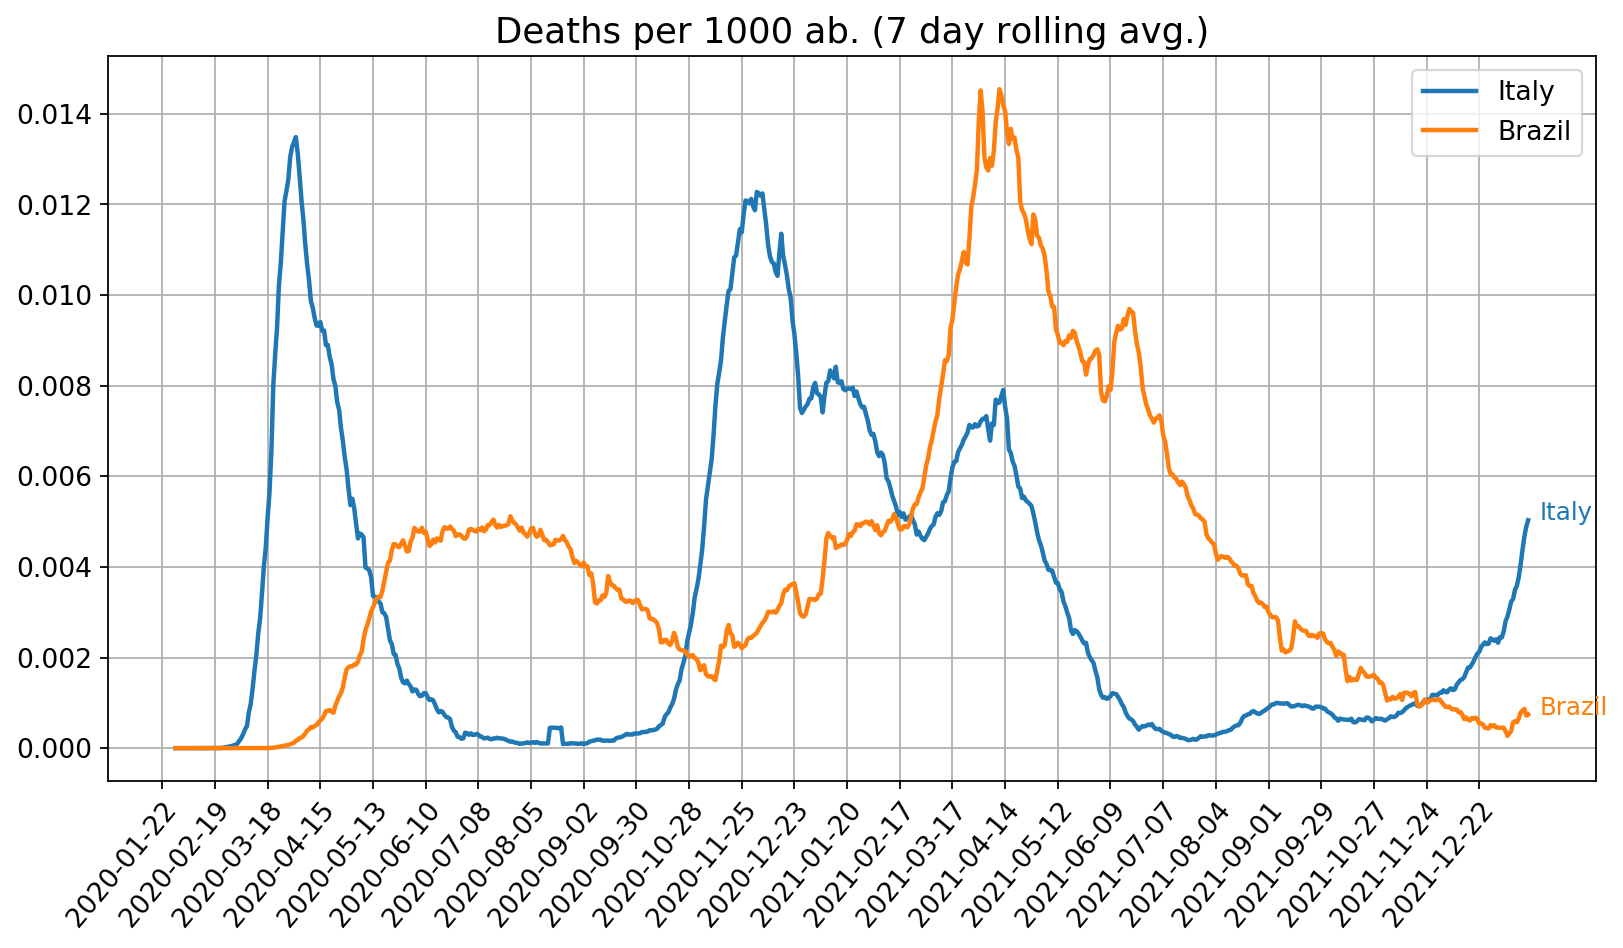

In [73]:
plot_per_million(df, 
                 varname="daily_deaths_mean_7d_1000", 
                 country_list=["Italy", "Brazil"],
                 title="Deaths per 1000 ab. (7 day rolling avg.)",
                 suffix="ita_rwa",
                 logscale=False)

Last date: 2021-12-26 00:00:00


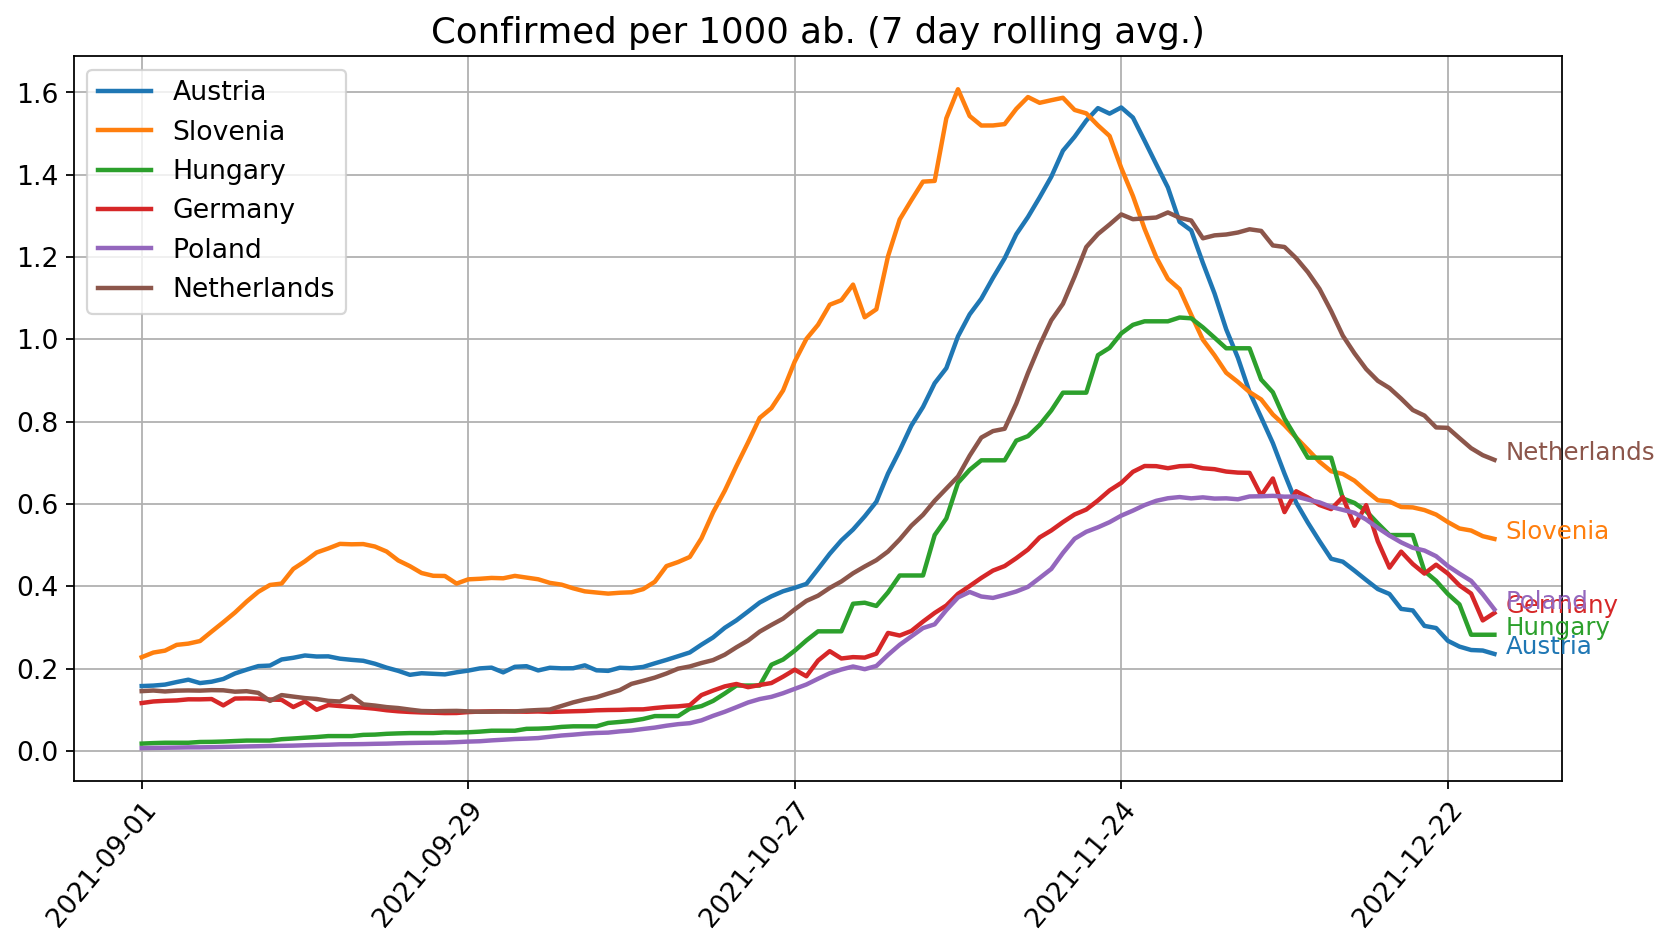

In [84]:
plot_per_million(df, 
                 varname="daily_confirmed_mean_7d_1000", 
                 country_list=["Austria", "Slovenia","Hungary", "Germany", "Poland","Netherlands"],
                 title="Confirmed per 1000 ab. (7 day rolling avg.)",
                 start_date="2021-09-01",
                 logscale=False)

In [76]:
hosp = pd.read_csv("./data/hospital_beds.csv")
hosp = hosp.set_index("LOCATION")
most_recent_year = pd.DataFrame(hosp.groupby("LOCATION")["TIME"].max())

In [77]:
hosp = hosp.join(most_recent_year, rsuffix="_last")

In [78]:
hosp = hosp[hosp["TIME_last"]==hosp["TIME"]]

In [79]:
import pycountry

countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_3

country_map = pd.DataFrame.from_dict(countries, orient="index", columns=["LOCATION"]).rename_axis("Country").reset_index()
country_map = country_map.set_index("LOCATION")
hosp = hosp.join(country_map)
hosp = hosp.rename(columns={"Value":"hospital_beds_100k"})
hosp = hosp[["Country", "hospital_beds_100k"]].reset_index()

In [80]:
hosp

LOCATION             Country  hospital_beds_100k
0       AUS           Australia                3.84
1       AUT             Austria                7.19
2       BEL             Belgium                5.54
3       CAN              Canada                2.52
4       CHE         Switzerland                4.59
5       DEU             Germany                7.91
6       DNK             Denmark                2.57
7       ESP               Spain                2.95
8       FIN             Finland                3.35
9       FRA              France                5.84
10      GBR      United Kingdom                2.42
11      IRL             Ireland                2.88
12      ITA               Italy                3.16
13      JPN               Japan               12.84
14      KOR  Korea, Republic of               12.44
15      NLD         Netherlands                3.08
16      NOR              Norway                3.47
17      PRT            Portugal                3.51
18      SWE              Sweden                2.07
19      USA       United States                2.83

In [81]:
df_scatt_hosp = df_scatt.merge(hosp, on="Country", how="inner")

/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


                                 OLS Regression Results                                
Dep. Variable:            deaths_1000   R-squared (uncentered):                   0.477
Model:                            OLS   Adj. R-squared (uncentered):              0.448
Method:                 Least Squares   F-statistic:                              16.43
Date:                Tue, 11 Jan 2022   Prob (F-statistic):                    0.000745
Time:                        22:03:39   Log-Likelihood:                         -29.184
No. Observations:                  19   AIC:                                      60.37
Df Residuals:                      18   BIC:                                      61.31
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

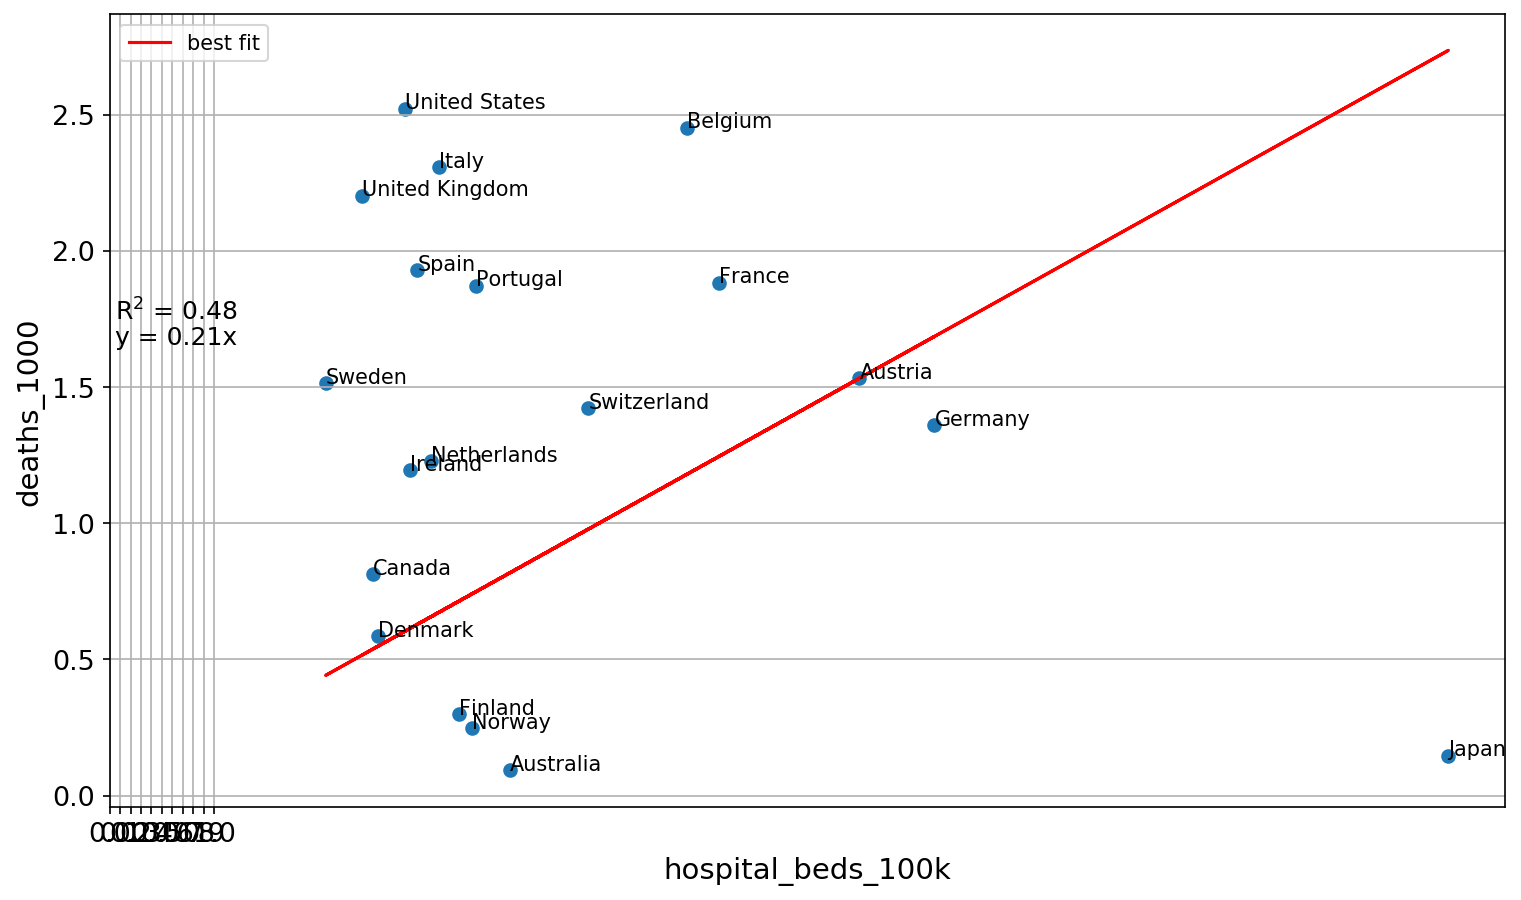

In [82]:
get_scatter_with_fit(df_scatt_hosp, 
                     yname="deaths_1000", 
                     xname="hospital_beds_100k")